In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [4]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/images-cleaned/104.American_Pipit)
49 samples in class 104, (./CU

60 samples in class 185, (./CUB_200_2011/CUB_200_2011/images-cleaned/186.Cedar_Waxwing)
50 samples in class 186, (./CUB_200_2011/CUB_200_2011/images-cleaned/187.American_Three_toed_Woodpecker)
60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned/19

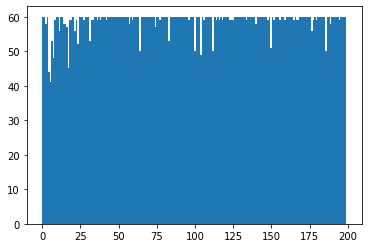

In [5]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))

In [29]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    label_in = Input(shape=(1,))
    label_embedding = Embedding(200, 100)(label_in)
    
    input_layer = multiply([noise_in, label_embedding])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, label_in], x)

In [7]:
generator = make_generator_model((100,))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       200         input_2[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 1, 100)       0           input_1[0][0]                    
                                                                 embedding[0][0]              

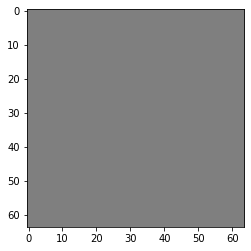

In [8]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)
label = 1

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [9]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    label = Dense(200, activation='softmax')(x)
    
    return Model(input_layer, [valid, label])

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()
valid, label = discriminator.predict(np.array([generated_image]))
print(valid)
print(label)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 64)   0           leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

In [11]:
cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [14]:
sparse_cce = SparseCategoricalCrossentropy(from_logits=False)
cce = CategoricalCrossentropy(from_logits=False)

'''
real_classes, fake_classes: List of class ints (0-200)
real_output, fake_output: List of softmax vectors
'''
def discriminator_class_loss(real_output, real_classes, flip):
    
#     if flip:
#         real_classes, fake_classes = fake_classes, real_classes
    
#     real_loss = sparse_cce(real_classes, real_output)
#     fake_loss = sparse_cce(fake_classes, fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss, real_loss, fake_loss

    return 2.0 * sparse_cce(real_classes, real_output)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [68]:
@tf.function
def train_step(images, labels, flip):
    noise = tf.random.truncated_normal([32, 100])
    sampled_labels = tf.cast(tf.random.uniform([32, 1], minval=0, maxval=200, dtype='int32'), 'float32')
    
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_class_real_losses = []
    disc_class_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, sampled_labels], training=True)
        
        real_output, real_label_output = discriminator(images, training=True)
        fake_output, fake_label_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
#         disc_class_loss, disc_class_real_loss, disc_class_fake_loss = discriminator_class_loss(real_label_output, labels, flip)
        disc_class_loss = discriminator_class_loss(real_label_output, labels, flip)
        
        disc_loss += disc_class_loss
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
#         disc_class_real_losses.append(K.mean(disc_class_real_loss))
#         disc_class_fake_losses.append(K.mean(disc_class_fake_loss))
        disc_class_real_losses.append(K.mean(disc_class_loss))
#         disc_class_fake_losses.append(K.mean(disc_class_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_class_real_losses)

In [56]:
def train(train_imgs, train_labels, epochs):
    gen_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_class_loss_real_all = []
    disc_class_loss_fake_all = []
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_class_loss_real_epoch = [1, 0]
#         disc_class_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_labels)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            gen_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_class_loss_real_batch = train_step(train_imgs[i:(i+32)], train_labels[i:(i+32)], batch_counter % 10 == 0)

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_class_loss_real_epoch[0] += 1
#             disc_class_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_class_loss_real_epoch[1] += np.mean(disc_class_loss_real_batch)
#             disc_class_loss_fake_epoch[1] += np.mean(disc_class_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc class real loss: {disc_class_loss_real_epoch[1]/disc_class_loss_real_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_class_loss_real_all.append(disc_class_loss_real_epoch[1]/disc_class_loss_real_epoch[0])
#         disc_class_loss_fake_all.append(disc_class_loss_fake_epoch[1]/disc_class_loss_fake_epoch[0])
    
    return (gen_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_class_loss_real_all)
    


In [62]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_class_real_hist=None, d_class_fake_hist=None, noise=None, label=None, save_files=False):
    
#     if noise is None:
#         noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []
        
    if d_real_hist is None:
        d_real_hist = []
    
    if d_fake_hist is None:
        d_fake_hist = []
        
    if d_class_real_hist is None:
        d_class_real_hist = []
        
    if d_class_fake_hist is None:
        d_class_fake_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_class_real_temp = train(train_imgs, train_classes, checkpoint_interval)
        g_hist += gen_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_class_real_hist += disc_class_real_temp
#         d_class_fake_hist += disc_class_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([label])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-conditional/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-conditional/gen_weights_conditional_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator.save_weights('./results/weights/bird-gan-conditional/disc_weights_conditional_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints

In [66]:
discriminator = make_discriminator_model()
generator = make_generator_model((100,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [67]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_class_loss_real_hist = []
disc_class_loss_fake_hist = []
noise100 = np.random.normal(0, 1, 100)
label = np.random.randint(0, 200)
next_starting_checkpoint = 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 16.572509288787842 sec
Gen loss: 1.6998505723185655, Disc loss: 11.498767519384865, Disc valid real loss: 0.47121327259353185, Disc valid fake loss: 0.46024806106962807, Disc class real loss: 10.567306187740833
Time for epoch 2 is 13.21348261833191 sec
Gen loss: 1.7439465244934165, Disc loss: 11.359361508997475, Disc valid real loss: 0.45642031458658255, Disc valid fake

Time for epoch 34 is 13.476580142974854 sec
Gen loss: 1.190180686108142, Disc loss: 4.998414819479635, Disc valid real loss: 0.6407186544846067, Disc valid fake loss: 0.567799940018796, Disc class real loss: 3.789896234264219
Time for epoch 35 is 13.432999849319458 sec
Gen loss: 1.1605788319091486, Disc loss: 4.8228480234378726, Disc valid real loss: 0.6314109260150733, Disc valid fake loss: 0.5787329666498231, Disc class real loss: 3.6127041187389755
Time for epoch 36 is 13.458373069763184 sec
Gen loss: 1.1615367935601935, Disc loss: 4.7147913838466655, Disc valid real loss: 0.626882944488267, Disc valid fake loss: 0.5858535902286933, Disc class real loss: 3.50205486899792
Time for epoch 37 is 13.543599367141724 sec
Gen loss: 1.1160301847186516, Disc loss: 4.553178545582262, Disc valid real loss: 0.6285872512716588, Disc valid fake loss: 0.5682539783196074, Disc class real loss: 3.356337320836902
Time for epoch 38 is 13.47794222831726 sec
Gen loss: 1.0728031639161149, Disc loss: 4.497

Time for epoch 70 is 13.516433477401733 sec
Gen loss: 1.0056149329596418, Disc loss: 2.69516150221269, Disc valid real loss: 0.6431775091463311, Disc valid fake loss: 0.6023982952280742, Disc class real loss: 1.4495856946884456
Time for epoch 71 is 13.512222051620483 sec
Gen loss: 0.9271476297843747, Disc loss: 2.6530393885403143, Disc valid real loss: 0.6408512862878764, Disc valid fake loss: 0.6432754365086233, Disc class real loss: 1.3689126613017344
Time for epoch 72 is 13.535082578659058 sec
Gen loss: 0.9477340798713974, Disc loss: 2.6326876749514243, Disc valid real loss: 0.6409608892147457, Disc valid fake loss: 0.6306902882529468, Disc class real loss: 1.3610365015219867
Time for epoch 73 is 13.574072360992432 sec
Gen loss: 0.9811418305244549, Disc loss: 2.5937608932738057, Disc valid real loss: 0.6336079136465946, Disc valid fake loss: 0.6123361184506558, Disc class real loss: 1.3478168607727299
Time for epoch 74 is 13.445940256118774 sec
Gen loss: 0.9980017953125765, Disc los

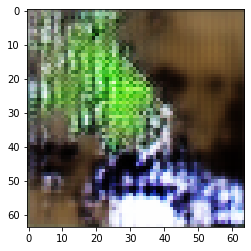

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.601332187652588 sec
Gen loss: 1.053504614326043, Disc loss: 2.132544943310704, Disc valid real loss: 0.6177782881550673, Disc valid fake loss: 0.6017984324677527, Disc class real loss: 0.9129682305220989
Time for epoch 2 is 13.570512533187866 sec
Gen loss: 1.0092475365817062, Disc loss: 2.1738662668036897, Disc valid real loss: 0.6270326948585873, Disc valid fake loss: 0.6165554505699695, Disc class real loss: 0.9302781232327304
Time for epoch 3 is 13.485774278640747 sec
Gen loss: 1.0295323871661655, Disc loss: 2.1549951022233422, Disc valid real loss: 0.6215341494981512, Disc valid fake loss: 0.6176905067470985, Disc class real loss: 0.915770445735797
Time for epoch 4 is 13.601366519927979 sec
Gen loss: 1.0870323048697577, Disc loss: 2.0939104518270106, Disc valid real loss: 0.6183121563780921, Disc valid fake loss: 0.5960340889165718, Disc class r

Time for epoch 37 is 13.572640419006348 sec
Gen loss: 0.9599417857522887, Disc loss: 1.9404980654962019, Disc valid real loss: 0.6271915611858937, Disc valid fake loss: 0.6331609509340147, Disc class real loss: 0.6801455518013739
Time for epoch 38 is 13.580158472061157 sec
Gen loss: 0.990724597196915, Disc loss: 1.9314387736281728, Disc valid real loss: 0.6233186288093163, Disc valid fake loss: 0.6189830889546775, Disc class real loss: 0.6891370552180582
Time for epoch 39 is 13.562247037887573 sec
Gen loss: 0.9728686071346769, Disc loss: 1.9210435940321222, Disc valid real loss: 0.6299443455730996, Disc valid fake loss: 0.6248477909784653, Disc class real loss: 0.6662514562085069
Time for epoch 40 is 13.570096731185913 sec
Gen loss: 1.0055232962295615, Disc loss: 1.868855394645112, Disc valid real loss: 0.6192407230051552, Disc valid fake loss: 0.6129294906851399, Disc class real loss: 0.6366851843671424
Time for epoch 41 is 13.585900068283081 sec
Gen loss: 0.996897775144758, Disc loss

Time for epoch 73 is 13.638177871704102 sec
Gen loss: 0.9558096393983215, Disc loss: 1.7935519657806975, Disc valid real loss: 0.6277986993473074, Disc valid fake loss: 0.6379743323416568, Disc class real loss: 0.5277789391900304
Time for epoch 74 is 13.556032419204712 sec
Gen loss: 0.9872826260279833, Disc loss: 1.7747683909527332, Disc valid real loss: 0.6325607021972739, Disc valid fake loss: 0.6133431608922436, Disc class real loss: 0.5288645259248532
Time for epoch 75 is 13.516718626022339 sec
Gen loss: 0.9606917474651078, Disc loss: 1.7899407109593957, Disc valid real loss: 0.6354021835456373, Disc valid fake loss: 0.6231118326749259, Disc class real loss: 0.5314266961875566
Time for epoch 76 is 13.643706321716309 sec
Gen loss: 0.9945409149335329, Disc loss: 1.762111948111516, Disc valid real loss: 0.6257317365023501, Disc valid fake loss: 0.613984240022132, Disc class real loss: 0.5223959718091378
Time for epoch 77 is 13.521502017974854 sec
Gen loss: 1.0392439089170316, Disc los

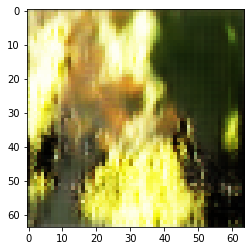

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.623242378234863 sec
Gen loss: 1.0368901072801937, Disc loss: 1.7033056259801393, Disc valid real loss: 0.6252455138740177, Disc valid fake loss: 0.6017342324502423, Disc class real loss: 0.47632587640508406
Time for epoch 2 is 13.60488224029541 sec
Gen loss: 1.0103729987532142, Disc loss: 1.7127081578986108, Disc valid real loss: 0.6329544626761904, Disc valid fake loss: 0.611193233954551, Disc class real loss: 0.46856046622482744
Time for epoch 3 is 13.584992170333862 sec
Gen loss: 1.020504372875865, Disc loss: 1.693187061687149, Disc valid real loss: 0.6178989540432204, Disc valid fake loss: 0.6100940318288519, Disc class real loss: 0.46519407066630153
Time for epoch 4 is 13.629523277282715 sec
Gen loss: 1.0094394191170772, Disc loss: 1.6838603116632478, Disc valid real loss: 0.6317191947766436, Disc valid fake loss: 0.6055439495781896, Disc class

Time for epoch 37 is 13.574353456497192 sec
Gen loss: 1.0065417221891202, Disc loss: 1.641644317283217, Disc valid real loss: 0.6247360836361159, Disc valid fake loss: 0.6012661935998819, Disc class real loss: 0.4156420365541285
Time for epoch 38 is 13.516311883926392 sec
Gen loss: 0.9901947167507679, Disc loss: 1.6522354885814636, Disc valid real loss: 0.6307876933880938, Disc valid fake loss: 0.6149268994324899, Disc class real loss: 0.4065208926918061
Time for epoch 39 is 13.531960248947144 sec
Gen loss: 0.9566779513023087, Disc loss: 1.6524198320176866, Disc valid real loss: 0.6366989370284042, Disc valid fake loss: 0.6204564850827866, Disc class real loss: 0.3952644077435055
Time for epoch 40 is 13.546134233474731 sec
Gen loss: 1.0291452892427522, Disc loss: 1.6210067092887754, Disc valid real loss: 0.6233505212517612, Disc valid fake loss: 0.5936427307807333, Disc class real loss: 0.40401345793142673
Time for epoch 41 is 13.644538640975952 sec
Gen loss: 0.9942148494203562, Disc l

Time for epoch 73 is 13.622761964797974 sec
Gen loss: 1.0666243984770323, Disc loss: 1.57908486302306, Disc valid real loss: 0.6200396748093085, Disc valid fake loss: 0.5913099216090308, Disc class real loss: 0.36773526382337257
Time for epoch 74 is 13.577619314193726 sec
Gen loss: 1.0938765640827375, Disc loss: 1.5783499036701067, Disc valid real loss: 0.6166615333498978, Disc valid fake loss: 0.5919431165304934, Disc class real loss: 0.3697452542844019
Time for epoch 75 is 13.563871383666992 sec
Gen loss: 1.0063572290143992, Disc loss: 1.5956337928448912, Disc valid real loss: 0.6213443884196966, Disc valid fake loss: 0.6114513707677847, Disc class real loss: 0.36283803939173215
Time for epoch 76 is 13.566272020339966 sec
Gen loss: 0.9996403132673848, Disc loss: 1.5685439116263453, Disc valid real loss: 0.6225832917987493, Disc valid fake loss: 0.6103842925573106, Disc class real loss: 0.33557632882501376
Time for epoch 77 is 13.562005996704102 sec
Gen loss: 1.0314218174151288, Disc 

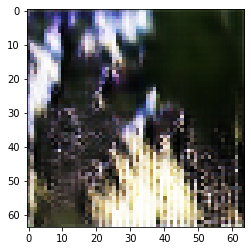

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 3

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.569875001907349 sec
Gen loss: 1.057990555033128, Disc loss: 1.5185928189657567, Disc valid real loss: 0.6092421838907691, Disc valid fake loss: 0.5950110665343318, Disc class real loss: 0.3143395693104482
Time for epoch 2 is 13.578350067138672 sec
Gen loss: 1.128308225130324, Disc loss: 1.5168873141128518, Disc valid real loss: 0.6025126278400421, Disc valid fake loss: 0.5787704403645947, Disc class real loss: 0.33560424597383676
Time for epoch 3 is 13.580525636672974 sec
Gen loss: 1.049664617392429, Disc loss: 1.5388333981599265, Disc valid real loss: 0.6197466040206795, Disc valid fake loss: 0.5988108930064411, Disc class real loss: 0.3202758993130672
Time for epoch 4 is 13.566385507583618 sec
Gen loss: 1.0429652551325357, Disc loss: 1.57275012805856, Disc valid real loss: 0.6191497290845163, Disc valid fake loss: 0.6032093696316406, Disc class re

Time for epoch 37 is 13.644514799118042 sec
Gen loss: 1.066494744967639, Disc loss: 1.5034856492587867, Disc valid real loss: 0.6198063592923689, Disc valid fake loss: 0.5826727949829928, Disc class real loss: 0.3010064936482769
Time for epoch 38 is 13.556125164031982 sec
Gen loss: 1.0243923053508852, Disc loss: 1.5447672800966072, Disc valid real loss: 0.6192609834961775, Disc valid fake loss: 0.5996738901629357, Disc class real loss: 0.32583240708866257
Time for epoch 39 is 13.506139516830444 sec
Gen loss: 1.0276051454427766, Disc loss: 1.5250736998348702, Disc valid real loss: 0.6136105895688541, Disc valid fake loss: 0.6029721445992064, Disc class real loss: 0.3084909682462451
Time for epoch 40 is 13.664870500564575 sec
Gen loss: 1.032071698164229, Disc loss: 1.5128713342232434, Disc valid real loss: 0.615366992750142, Disc valid fake loss: 0.5992185280413486, Disc class real loss: 0.2982858144186013
Time for epoch 41 is 13.512247800827026 sec
Gen loss: 1.1433535961277763, Disc los

Time for epoch 73 is 13.539452314376831 sec
Gen loss: 1.085749575277654, Disc loss: 1.4871996597545902, Disc valid real loss: 0.6097554964263264, Disc valid fake loss: 0.5814413148859329, Disc class real loss: 0.29600284604209304
Time for epoch 74 is 13.56645131111145 sec
Gen loss: 1.0998702684069068, Disc loss: 1.4541471169246891, Disc valid real loss: 0.6081637286235323, Disc valid fake loss: 0.5819753829218185, Disc class real loss: 0.2640080079682383
Time for epoch 75 is 13.55462908744812 sec
Gen loss: 1.0421906688672093, Disc loss: 1.515666339132521, Disc valid real loss: 0.6183114115623277, Disc valid fake loss: 0.5916474307294137, Disc class real loss: 0.30570750044239814
Time for epoch 76 is 13.578066349029541 sec
Gen loss: 1.0741968227595817, Disc loss: 1.4723576832269911, Disc valid real loss: 0.610397911572521, Disc valid fake loss: 0.5903907618548488, Disc class real loss: 0.27156900698672426
Time for epoch 77 is 13.56164813041687 sec
Gen loss: 1.159125203847239, Disc loss:

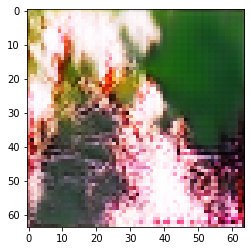

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.569130182266235 sec
Gen loss: 1.0379077431955313, Disc loss: 1.4967788832620554, Disc valid real loss: 0.6215290524126068, Disc valid fake loss: 0.5898775264499633, Disc class real loss: 0.2853723081689439
Time for epoch 2 is 13.582022190093994 sec
Gen loss: 1.028116417448049, Disc loss: 1.471068639257736, Disc valid real loss: 0.6205479621402616, Disc valid fake loss: 0.5925645044825587, Disc class real loss: 0.25795617434107837
Time for epoch 3 is 13.574529647827148 sec
Gen loss: 1.0640373181521408, Disc loss: 1.489478238068299, Disc valid real loss: 0.6216989678095995, Disc valid fake loss: 0.5868749123440202, Disc class real loss: 0.28090435868699537
Time for epoch 4 is 13.599034786224365 sec
Gen loss: 1.06622874833704, Disc loss: 1.461195135019659, Disc valid real loss: 0.6191234851917278, Disc valid fake loss: 0.5804643757782655, Disc class re

Time for epoch 37 is 13.703293800354004 sec
Gen loss: 1.0459470572833447, Disc loss: 1.4526063006744798, Disc valid real loss: 0.6152226655948453, Disc valid fake loss: 0.593513897440944, Disc class real loss: 0.2438697400490241
Time for epoch 38 is 13.609429121017456 sec
Gen loss: 1.0607012573296462, Disc loss: 1.4545839596893082, Disc valid real loss: 0.6145877758984967, Disc valid fake loss: 0.5827631160495726, Disc class real loss: 0.2572330671948126
Time for epoch 39 is 13.527596473693848 sec
Gen loss: 1.0676736557063695, Disc loss: 1.4534077169449349, Disc valid real loss: 0.6171197309726622, Disc valid fake loss: 0.5794020984877093, Disc class real loss: 0.2568858882341645
Time for epoch 40 is 13.516865968704224 sec
Gen loss: 1.0720739382392346, Disc loss: 1.4531409897132295, Disc valid real loss: 0.6151212351270484, Disc valid fake loss: 0.5831450885388909, Disc class real loss: 0.254874665798685
Time for epoch 41 is 13.617786645889282 sec
Gen loss: 1.0526269546692288, Disc los

Time for epoch 73 is 13.585552453994751 sec
Gen loss: 1.0607495325690686, Disc loss: 1.4474422212861742, Disc valid real loss: 0.618748528524466, Disc valid fake loss: 0.5778674085127306, Disc class real loss: 0.2508262790547719
Time for epoch 74 is 13.545668840408325 sec
Gen loss: 1.0353836842022615, Disc loss: 1.4486516917624124, Disc valid real loss: 0.6245908581305971, Disc valid fake loss: 0.5898953671377849, Disc class real loss: 0.23416546588955411
Time for epoch 75 is 13.576443195343018 sec
Gen loss: 1.0612350534294357, Disc loss: 1.4193178471834034, Disc valid real loss: 0.6076174333166624, Disc valid fake loss: 0.5780420875969295, Disc class real loss: 0.23365832849716148
Time for epoch 76 is 13.594048976898193 sec
Gen loss: 1.0963654094918311, Disc loss: 1.4329219764164147, Disc valid real loss: 0.6152260433529128, Disc valid fake loss: 0.5719199707191488, Disc class real loss: 0.24577596063566645
Time for epoch 77 is 13.586970567703247 sec
Gen loss: 1.033899283667567, Disc 

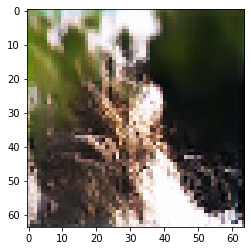

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 5

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.56954312324524 sec
Gen loss: 1.0661820320256035, Disc loss: 1.4136251721601822, Disc valid real loss: 0.616358154430622, Disc valid fake loss: 0.576142916592156, Disc class real loss: 0.2211241011184749
Time for epoch 2 is 13.587724447250366 sec
Gen loss: 1.0049985631048517, Disc loss: 1.455656163091582, Disc valid real loss: 0.6303196288544312, Disc valid fake loss: 0.590915985546784, Disc class real loss: 0.2344205509883864
Time for epoch 3 is 13.569822788238525 sec
Gen loss: 1.0678645858596656, Disc loss: 1.4012091292275324, Disc valid real loss: 0.6232609939445971, Disc valid fake loss: 0.5803768344041778, Disc class real loss: 0.19757129935684
Time for epoch 4 is 13.586699485778809 sec
Gen loss: 1.0507653659275231, Disc loss: 1.412981924164263, Disc valid real loss: 0.6216633860980915, Disc valid fake loss: 0.5780990564726233, Disc class real l

Time for epoch 37 is 13.597311019897461 sec
Gen loss: 1.0450321959286202, Disc loss: 1.4172467578071242, Disc valid real loss: 0.6222726745495628, Disc valid fake loss: 0.5800687720782065, Disc class real loss: 0.21490530838033936
Time for epoch 38 is 13.59045147895813 sec
Gen loss: 1.0916806685569163, Disc loss: 1.394310157150434, Disc valid real loss: 0.6100731942711807, Disc valid fake loss: 0.5738434978132325, Disc class real loss: 0.2103934676744811
Time for epoch 39 is 13.642836093902588 sec
Gen loss: 1.0577953599978915, Disc loss: 1.4107817377501386, Disc valid real loss: 0.617368952207126, Disc valid fake loss: 0.577308827541708, Disc class real loss: 0.21610396109246283
Time for epoch 40 is 13.547900199890137 sec
Gen loss: 1.0645916019351824, Disc loss: 1.4081776271344524, Disc valid real loss: 0.6181877232017879, Disc valid fake loss: 0.5743309882921255, Disc class real loss: 0.21565891514206684
Time for epoch 41 is 13.542828559875488 sec
Gen loss: 1.105245911493534, Disc los

Time for epoch 73 is 13.518843650817871 sec
Gen loss: 1.0339717214023518, Disc loss: 1.430761863868734, Disc valid real loss: 0.6251959862909343, Disc valid fake loss: 0.5743639986851028, Disc class real loss: 0.23120187707169632
Time for epoch 74 is 13.564285516738892 sec
Gen loss: 1.0258672608915707, Disc loss: 1.4173713101927181, Disc valid real loss: 0.6317315329381121, Disc valid fake loss: 0.5783310863706801, Disc class real loss: 0.20730868708134093
Time for epoch 75 is 13.694207668304443 sec
Gen loss: 1.0624418903172501, Disc loss: 1.3925776131107879, Disc valid real loss: 0.6148132915257761, Disc valid fake loss: 0.5709546445831051, Disc class real loss: 0.20680967684163837
Time for epoch 76 is 13.502264261245728 sec
Gen loss: 1.0462572220864335, Disc loss: 1.4316256411353423, Disc valid real loss: 0.6303059457117303, Disc valid fake loss: 0.5750829086394168, Disc class real loss: 0.22623678928854443
Time for epoch 77 is 13.641146421432495 sec
Gen loss: 1.0646435437486748, Dis

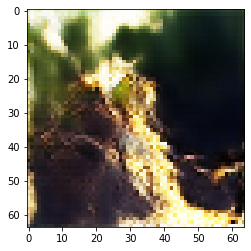

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 6

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.606530666351318 sec
Gen loss: 1.0836115760531853, Disc loss: 1.4049386246417597, Disc valid real loss: 0.6180146304249441, Disc valid fake loss: 0.5687204410390156, Disc class real loss: 0.2182035523045273
Time for epoch 2 is 13.568605899810791 sec
Gen loss: 1.0323338956044619, Disc loss: 1.4116505995029356, Disc valid real loss: 0.6227299412737693, Disc valid fake loss: 0.5816765494624451, Disc class real loss: 0.2072441124945354
Time for epoch 3 is 13.595680952072144 sec
Gen loss: 1.0643422925052282, Disc loss: 1.4071385947669424, Disc valid real loss: 0.6165917438220202, Disc valid fake loss: 0.5712772079599582, Disc class real loss: 0.21926964117910683
Time for epoch 4 is 13.57584285736084 sec
Gen loss: 1.060162136709787, Disc loss: 1.4067219062872371, Disc valid real loss: 0.6286044209630186, Disc valid fake loss: 0.5748735603278246, Disc class

Time for epoch 37 is 13.544586420059204 sec
Gen loss: 1.0646984304192912, Disc loss: 1.3883933008201723, Disc valid real loss: 0.6257335008159886, Disc valid fake loss: 0.5761910781950809, Disc class real loss: 0.18646871849584082
Time for epoch 38 is 13.571546077728271 sec
Gen loss: 0.9876617149608892, Disc loss: 1.4309414067888648, Disc valid real loss: 0.6408976684740888, Disc valid fake loss: 0.5890797595506115, Disc class real loss: 0.20096397742239108
Time for epoch 39 is 13.590498447418213 sec
Gen loss: 1.0394465503330799, Disc loss: 1.3953982727314398, Disc valid real loss: 0.6306558966152067, Disc valid fake loss: 0.5747168626242537, Disc class real loss: 0.19002551108416987
Time for epoch 40 is 13.62331223487854 sec
Gen loss: 1.0535736308511356, Disc loss: 1.3937878464941733, Disc valid real loss: 0.6141150901472665, Disc valid fake loss: 0.5787931707331805, Disc class real loss: 0.20087958505341838
Time for epoch 41 is 13.552652597427368 sec
Gen loss: 1.0574679361772408, Dis

Time for epoch 73 is 13.54413628578186 sec
Gen loss: 1.0553753073945602, Disc loss: 1.3957870663989205, Disc valid real loss: 0.6181601776178614, Disc valid fake loss: 0.5716653532452054, Disc class real loss: 0.20596153151211113
Time for epoch 74 is 13.574281930923462 sec
Gen loss: 1.0416038927993154, Disc loss: 1.3990596380983265, Disc valid real loss: 0.6283439497960616, Disc valid fake loss: 0.5736333679377548, Disc class real loss: 0.1970823186299534
Time for epoch 75 is 13.572938442230225 sec
Gen loss: 1.0367160436260667, Disc loss: 1.3756251606514784, Disc valid real loss: 0.6256293797396063, Disc valid fake loss: 0.5709851244439278, Disc class real loss: 0.17901065680362427
Time for epoch 76 is 13.546169757843018 sec
Gen loss: 1.045601571640025, Disc loss: 1.3979785746029076, Disc valid real loss: 0.6295814911524454, Disc valid fake loss: 0.5744679234215238, Disc class real loss: 0.19392916076465794
Time for epoch 77 is 13.555514812469482 sec
Gen loss: 1.0078906982248714, Disc 

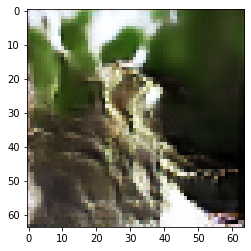

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 7

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.661872863769531 sec
Gen loss: 0.9552034658145129, Disc loss: 1.411044000287043, Disc valid real loss: 0.6501149154775511, Disc valid fake loss: 0.5929597742189237, Disc class real loss: 0.1679693084048627
Time for epoch 2 is 13.625301837921143 sec
Gen loss: 0.9749854916156468, Disc loss: 1.39880509008237, Disc valid real loss: 0.636363489033407, Disc valid fake loss: 0.5930631524986691, Disc class real loss: 0.16937845299237467
Time for epoch 3 is 13.500629901885986 sec
Gen loss: 0.9723619471397503, Disc loss: 1.407320216419251, Disc valid real loss: 0.6407418821239212, Disc valid fake loss: 0.5909629678984645, Disc class real loss: 0.17561536710450631
Time for epoch 4 is 13.516135931015015 sec
Gen loss: 0.9843471901526619, Disc loss: 1.3951366711761246, Disc valid real loss: 0.6358482794063848, Disc valid fake loss: 0.5892503860843213, Disc class r

Time for epoch 37 is 13.529309034347534 sec
Gen loss: 0.9719100662363254, Disc loss: 1.409546070628696, Disc valid real loss: 0.6405039471662465, Disc valid fake loss: 0.5870978151395069, Disc class real loss: 0.18194430824312405
Time for epoch 38 is 13.659192323684692 sec
Gen loss: 1.0032685242371184, Disc loss: 1.409851656858191, Disc valid real loss: 0.6388022300350634, Disc valid fake loss: 0.5806943494776077, Disc class real loss: 0.1903550770461211
Time for epoch 39 is 13.46977186203003 sec
Gen loss: 0.9890954920916053, Disc loss: 1.3949583579854268, Disc valid real loss: 0.6410579221035407, Disc valid fake loss: 0.5858839698600252, Disc class real loss: 0.16801646917548566
Time for epoch 40 is 13.704719305038452 sec
Gen loss: 0.9426052080906504, Disc loss: 1.41694114815575, Disc valid real loss: 0.6430178590744815, Disc valid fake loss: 0.6012182423092809, Disc class real loss: 0.172705046254113
Time for epoch 41 is 13.528117418289185 sec
Gen loss: 0.9387064878210466, Disc loss:

Time for epoch 73 is 13.638395309448242 sec
Gen loss: 0.9314310016024726, Disc loss: 1.426688695341591, Disc valid real loss: 0.6480406007469508, Disc valid fake loss: 0.6020896030150777, Disc class real loss: 0.17655849200468335
Time for epoch 74 is 13.566840171813965 sec
Gen loss: 0.9223998453882005, Disc loss: 1.4037432925810982, Disc valid real loss: 0.6503303543661991, Disc valid fake loss: 0.6017177512813713, Disc class real loss: 0.15169518942273347
Time for epoch 75 is 13.576168537139893 sec
Gen loss: 0.9435698792217223, Disc loss: 1.4109522727769888, Disc valid real loss: 0.6446954969791215, Disc valid fake loss: 0.5982324560967888, Disc class real loss: 0.16802431926917447
Time for epoch 76 is 13.579614877700806 sec
Gen loss: 0.9169290555201894, Disc loss: 1.4410232289373712, Disc valid real loss: 0.6549303874090758, Disc valid fake loss: 0.6048306473871556, Disc class real loss: 0.18126219455821585
Time for epoch 77 is 13.691607236862183 sec
Gen loss: 0.9193159020367031, Dis

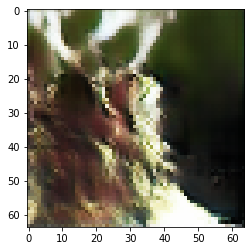

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 8

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.489242792129517 sec
Gen loss: 0.9309303421315139, Disc loss: 1.4236400146794512, Disc valid real loss: 0.6518259492669971, Disc valid fake loss: 0.6027126497207942, Disc class real loss: 0.16910141043120183
Time for epoch 2 is 13.599809885025024 sec
Gen loss: 0.9228552975628758, Disc loss: 1.4401638275239526, Disc valid real loss: 0.6481030870905413, Disc valid fake loss: 0.6043202126736886, Disc class real loss: 0.18774052911506192
Time for epoch 3 is 13.563217401504517 sec
Gen loss: 0.9208397191714465, Disc loss: 1.4219395484381574, Disc valid real loss: 0.6460670331306251, Disc valid fake loss: 0.606442674792556, Disc class real loss: 0.16942983591089247
Time for epoch 4 is 13.562114000320435 sec
Gen loss: 0.9297068687635386, Disc loss: 1.4230724017471479, Disc valid real loss: 0.647864196843248, Disc valid fake loss: 0.6021172223375418, Disc cla

Time for epoch 37 is 13.579558849334717 sec
Gen loss: 0.920535876498959, Disc loss: 1.406757460700141, Disc valid real loss: 0.6476601987350278, Disc valid fake loss: 0.6051752732052067, Disc class real loss: 0.1539219847260684
Time for epoch 38 is 13.542858600616455 sec
Gen loss: 0.9198656077307414, Disc loss: 1.4158980445810128, Disc valid real loss: 0.6506168165504125, Disc valid fake loss: 0.6061770854603631, Disc class real loss: 0.15910414436221285
Time for epoch 39 is 13.558175325393677 sec
Gen loss: 0.9380965531679996, Disc loss: 1.4237117376430894, Disc valid real loss: 0.6521627255248507, Disc valid fake loss: 0.599547099534089, Disc class real loss: 0.1720019099744274
Time for epoch 40 is 13.550785779953003 sec
Gen loss: 0.8906285630332099, Disc loss: 1.4542124255239801, Disc valid real loss: 0.6628746517951573, Disc valid fake loss: 0.6190317022768139, Disc class real loss: 0.1723060746258251
Time for epoch 41 is 13.630981922149658 sec
Gen loss: 0.9024792914468098, Disc los

Time for epoch 73 is 13.57106351852417 sec
Gen loss: 0.8885093260263686, Disc loss: 1.415253495459311, Disc valid real loss: 0.6548159247652948, Disc valid fake loss: 0.6152554131781829, Disc class real loss: 0.145182150643859
Time for epoch 74 is 13.619834661483765 sec
Gen loss: 0.8967521122800626, Disc loss: 1.4189394844902887, Disc valid real loss: 0.6553449114648308, Disc valid fake loss: 0.6101550297523902, Disc class real loss: 0.15343954198208806
Time for epoch 75 is 13.602744102478027 sec
Gen loss: 0.900594689012543, Disc loss: 1.4420758808854472, Disc valid real loss: 0.6538433284778905, Disc valid fake loss: 0.6135755992194178, Disc class real loss: 0.1746569552621615
Time for epoch 76 is 13.585102796554565 sec
Gen loss: 0.916069288402392, Disc loss: 1.4235870447262193, Disc valid real loss: 0.6498651546514455, Disc valid fake loss: 0.6100937628002994, Disc class real loss: 0.16362812171067392
Time for epoch 77 is 13.554351091384888 sec
Gen loss: 0.9208610453579807, Disc loss

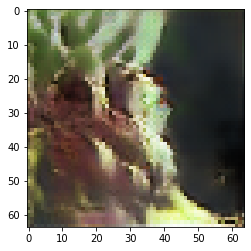

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 9

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.668907880783081 sec
Gen loss: 0.8873773094438279, Disc loss: 1.446553299097511, Disc valid real loss: 0.6659767647099689, Disc valid fake loss: 0.6163631785852799, Disc class real loss: 0.164213357217702
Time for epoch 2 is 13.543145418167114 sec
Gen loss: 0.8940102362697363, Disc loss: 1.4255732892328485, Disc valid real loss: 0.663247852467586, Disc valid fake loss: 0.6145793432950327, Disc class real loss: 0.14774609339577435
Time for epoch 3 is 13.653608322143555 sec
Gen loss: 0.8789486849534156, Disc loss: 1.436964535131687, Disc valid real loss: 0.6615362063171418, Disc valid fake loss: 0.6217158739644337, Disc class real loss: 0.1537124559189872
Time for epoch 4 is 13.536819219589233 sec
Gen loss: 0.8704550432641978, Disc loss: 1.4213011416639416, Disc valid real loss: 0.6637897800785416, Disc valid fake loss: 0.6177197211803136, Disc class r

Time for epoch 37 is 13.696440935134888 sec
Gen loss: 0.8815771241175127, Disc loss: 1.4252124882648953, Disc valid real loss: 0.6593229773891004, Disc valid fake loss: 0.6148245904826859, Disc class real loss: 0.15106492135392977
Time for epoch 38 is 13.54238748550415 sec
Gen loss: 0.8791810673103746, Disc loss: 1.4400641730807338, Disc valid real loss: 0.6659497822203287, Disc valid fake loss: 0.6169428695346605, Disc class real loss: 0.15717151902898702
Time for epoch 39 is 13.602893114089966 sec
Gen loss: 0.8712999105130431, Disc loss: 1.4367049402660794, Disc valid real loss: 0.6548594435056051, Disc valid fake loss: 0.6219100728429107, Disc class real loss: 0.1599354205326856
Time for epoch 40 is 13.59731411933899 sec
Gen loss: 0.8737323182385143, Disc loss: 1.431985009330398, Disc valid real loss: 0.6694034501142941, Disc valid fake loss: 0.6178803553749229, Disc class real loss: 0.1447012044702654
Time for epoch 41 is 13.554004907608032 sec
Gen loss: 0.8705859647856818, Disc lo

Time for epoch 73 is 13.607077836990356 sec
Gen loss: 0.8581216403139316, Disc loss: 1.431587926094448, Disc valid real loss: 0.663254020498374, Disc valid fake loss: 0.6237947706607622, Disc class real loss: 0.14453913769899265
Time for epoch 74 is 13.580089092254639 sec
Gen loss: 0.8487977702120132, Disc loss: 1.44996632502331, Disc valid real loss: 0.6663691689005389, Disc valid fake loss: 0.6253614420813274, Disc class real loss: 0.15823571187151259
Time for epoch 75 is 13.603719472885132 sec
Gen loss: 0.8503331445096954, Disc loss: 1.4508813012260084, Disc valid real loss: 0.6615889834033118, Disc valid fake loss: 0.6299903188456042, Disc class real loss: 0.15930199406777323
Time for epoch 76 is 13.574942111968994 sec
Gen loss: 0.8384558584308883, Disc loss: 1.4720487058324219, Disc valid real loss: 0.6705757527331996, Disc valid fake loss: 0.6334934128009206, Disc class real loss: 0.16797954118687553
Time for epoch 77 is 13.611451148986816 sec
Gen loss: 0.8407826937311064, Disc l

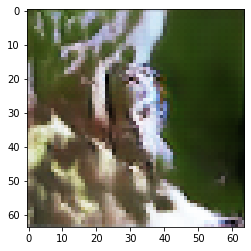

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.64834713935852 sec
Gen loss: 0.8366931591253617, Disc loss: 1.4340064050705452, Disc valid real loss: 0.6646263226260983, Disc valid fake loss: 0.6327476537001488, Disc class real loss: 0.1366324230908198
Time for epoch 2 is 13.548608303070068 sec
Gen loss: 0.8349868766660613, Disc loss: 1.446888408363673, Disc valid real loss: 0.6748893664781317, Disc valid fake loss: 0.6308240754817559, Disc class real loss: 0.14117496828362472
Time for epoch 3 is 13.618279457092285 sec
Gen loss: 0.8318938396487455, Disc loss: 1.4385618514161769, Disc valid real loss: 0.6680491636116007, Disc valid fake loss: 0.635963206207203, Disc class real loss: 0.13454948000360323
Time for epoch 4 is 13.563017845153809 sec
Gen loss: 0.8316288226988258, Disc loss: 1.4522100738716643, Disc valid real loss: 0.676725215220516, Disc valid fake loss: 0.630225854514414, Disc class 

Time for epoch 37 is 13.508999586105347 sec
Gen loss: 0.8267539523158293, Disc loss: 1.4459295269596544, Disc valid real loss: 0.6761184948569714, Disc valid fake loss: 0.6360592420508222, Disc class real loss: 0.133751783141949
Time for epoch 38 is 13.59863567352295 sec
Gen loss: 0.8204706908887641, Disc loss: 1.451420188596255, Disc valid real loss: 0.6709637724287142, Disc valid fake loss: 0.6372147347868943, Disc class real loss: 0.14324167748089112
Time for epoch 39 is 13.539733409881592 sec
Gen loss: 0.8051582301858318, Disc loss: 1.4734595774958128, Disc valid real loss: 0.6766553629381546, Disc valid fake loss: 0.6441218097035478, Disc class real loss: 0.15268240652241438
Time for epoch 40 is 13.690903663635254 sec
Gen loss: 0.8154679446362545, Disc loss: 1.4528541833081543, Disc valid real loss: 0.6824223281245244, Disc valid fake loss: 0.6405031622909918, Disc class real loss: 0.12992869412525226
Time for epoch 41 is 13.662644624710083 sec
Gen loss: 0.7984258774819413, Disc l

Time for epoch 73 is 13.500301837921143 sec
Gen loss: 0.8105130339379556, Disc loss: 1.4400546696127914, Disc valid real loss: 0.676596061000979, Disc valid fake loss: 0.6416627813160904, Disc class real loss: 0.1217958280547878
Time for epoch 74 is 13.696377038955688 sec
Gen loss: 0.8056228689061917, Disc loss: 1.4773826376209414, Disc valid real loss: 0.683302828289952, Disc valid fake loss: 0.6447692045028294, Disc class real loss: 0.1493106039529944
Time for epoch 75 is 13.59187626838684 sec
Gen loss: 0.7961514760162126, Disc loss: 1.4680072750825546, Disc valid real loss: 0.6731308491895516, Disc valid fake loss: 0.647104917664515, Disc class real loss: 0.14777151008056436
Time for epoch 76 is 13.564281702041626 sec
Gen loss: 0.7875837835516064, Disc loss: 1.4640457895067003, Disc valid real loss: 0.6709636884330088, Disc valid fake loss: 0.6534757599598024, Disc class real loss: 0.1396063437433295
Time for epoch 77 is 13.574243545532227 sec
Gen loss: 0.8165823658953514, Disc loss

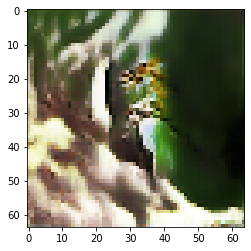

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.544706106185913 sec
Gen loss: 0.7835331911317055, Disc loss: 1.4752761542312498, Disc valid real loss: 0.6763113389816388, Disc valid fake loss: 0.6542222504693318, Disc class real loss: 0.14474256460258023
Time for epoch 2 is 13.565309047698975 sec
Gen loss: 0.7855433333856949, Disc loss: 1.4733191395839702, Disc valid real loss: 0.6757043120337696, Disc valid fake loss: 0.6522391989302183, Disc class real loss: 0.1453756267205827
Time for epoch 3 is 13.607048511505127 sec
Gen loss: 0.7805964811061455, Disc loss: 1.4695486069371706, Disc valid real loss: 0.6824803741643746, Disc valid fake loss: 0.6527090150166334, Disc class real loss: 0.13435921573545784
Time for epoch 4 is 13.687175512313843 sec
Gen loss: 0.7817062393113526, Disc loss: 1.4493366237578353, Disc valid real loss: 0.6754407402945728, Disc valid fake loss: 0.6558690213252535, Disc c

Time for epoch 37 is 13.567652702331543 sec
Gen loss: 0.7690777609018775, Disc loss: 1.466631850576013, Disc valid real loss: 0.6781480790476812, Disc valid fake loss: 0.6606626710917568, Disc class real loss: 0.1278210938494081
Time for epoch 38 is 13.572122812271118 sec
Gen loss: 0.7686813646538794, Disc loss: 1.4700789112385695, Disc valid real loss: 0.6849219837808996, Disc valid fake loss: 0.6589882527263506, Disc class real loss: 0.12616867272694074
Time for epoch 39 is 13.51044511795044 sec
Gen loss: 0.7659921022611582, Disc loss: 1.4609822726185082, Disc valid real loss: 0.6754736019989985, Disc valid fake loss: 0.6606244092711265, Disc class real loss: 0.12488426425955498
Time for epoch 40 is 13.56264591217041 sec
Gen loss: 0.7627098175891369, Disc loss: 1.4777627472631976, Disc valid real loss: 0.6795632955504627, Disc valid fake loss: 0.661928530146436, Disc class real loss: 0.13627091463611696
Time for epoch 41 is 13.59217619895935 sec
Gen loss: 0.7654532189291667, Disc los

Time for epoch 73 is 13.586791038513184 sec
Gen loss: 0.7611365216534313, Disc loss: 1.4688175121943157, Disc valid real loss: 0.6798017486970276, Disc valid fake loss: 0.6630436563233373, Disc class real loss: 0.12597210795407532
Time for epoch 74 is 13.679385900497437 sec
Gen loss: 0.7623388292343636, Disc loss: 1.4726407922057279, Disc valid real loss: 0.6812045289895076, Disc valid fake loss: 0.6623725404907371, Disc class real loss: 0.12906372386155787
Time for epoch 75 is 13.594730615615845 sec
Gen loss: 0.7639887630131833, Disc loss: 1.4752660188571547, Disc valid real loss: 0.6838593885181395, Disc valid fake loss: 0.6619425961964822, Disc class real loss: 0.12946403714188381
Time for epoch 76 is 13.555783033370972 sec
Gen loss: 0.7560129687391969, Disc loss: 1.470518391952928, Disc valid real loss: 0.6799544276906869, Disc valid fake loss: 0.6651257772432756, Disc class real loss: 0.12543818697211556
Time for epoch 77 is 13.64035177230835 sec
Gen loss: 0.7576281481642064, Disc

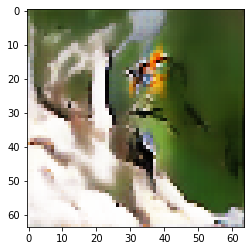

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.575414896011353 sec
Gen loss: 0.7538816631647952, Disc loss: 1.4773010387007137, Disc valid real loss: 0.6801149229693219, Disc valid fake loss: 0.6655087248096622, Disc class real loss: 0.1316773893499651
Time for epoch 2 is 13.59171748161316 sec
Gen loss: 0.7587497914386635, Disc loss: 1.4813032444253524, Disc valid real loss: 0.6852199084713531, Disc valid fake loss: 0.6643210594570087, Disc class real loss: 0.13176227620327063
Time for epoch 3 is 13.584376811981201 sec
Gen loss: 0.7566546421387008, Disc loss: 1.4689664850390054, Disc valid real loss: 0.6853120063701619, Disc valid fake loss: 0.6649210404574386, Disc class real loss: 0.11873343632805576
Time for epoch 4 is 13.579480171203613 sec
Gen loss: 0.7537088213251212, Disc loss: 1.4746277106163626, Disc valid real loss: 0.6804116255222621, Disc valid fake loss: 0.6669432459484917, Disc cl

Time for epoch 37 is 13.5965735912323 sec
Gen loss: 0.7407198318944068, Disc loss: 1.481417128064122, Disc valid real loss: 0.6848034160893138, Disc valid fake loss: 0.6736806970301682, Disc class real loss: 0.12293301138024888
Time for epoch 38 is 13.605362892150879 sec
Gen loss: 0.7396407754117558, Disc loss: 1.4680875749768927, Disc valid real loss: 0.6871888715077222, Disc valid fake loss: 0.672798585439439, Disc class real loss: 0.10810011824489468
Time for epoch 39 is 13.569211721420288 sec
Gen loss: 0.7453560914773605, Disc loss: 1.4661229800402633, Disc valid real loss: 0.6875331020613673, Disc valid fake loss: 0.670713425328738, Disc class real loss: 0.1078764497625888
Time for epoch 40 is 13.585826396942139 sec
Gen loss: 0.7532330492970744, Disc loss: 1.4788499682899412, Disc valid real loss: 0.6889648203281206, Disc valid fake loss: 0.6649011837111579, Disc class real loss: 0.12498396714907697
Time for epoch 41 is 13.602699518203735 sec
Gen loss: 0.738471476850794, Disc loss

Time for epoch 73 is 13.578849792480469 sec
Gen loss: 0.7363210239707616, Disc loss: 1.492319131608255, Disc valid real loss: 0.688074563415393, Disc valid fake loss: 0.67415994841878, Disc class real loss: 0.13008462365940376
Time for epoch 74 is 13.602800607681274 sec
Gen loss: 0.7328534568874494, Disc loss: 1.4864177823389773, Disc valid real loss: 0.6888888189140051, Disc valid fake loss: 0.676384610050739, Disc class real loss: 0.1211443510001808
Time for epoch 75 is 13.580571174621582 sec
Gen loss: 0.7245210021491942, Disc loss: 1.4797786141475688, Disc valid real loss: 0.6841178975777251, Disc valid fake loss: 0.6803525833256523, Disc class real loss: 0.11530813611253558
Time for epoch 76 is 13.579335927963257 sec
Gen loss: 0.7296336579128979, Disc loss: 1.4971144134759258, Disc valid real loss: 0.6859957782556694, Disc valid fake loss: 0.6775088105098341, Disc class real loss: 0.13360982155995216
Time for epoch 77 is 13.569377183914185 sec
Gen loss: 0.7248775794254085, Disc los

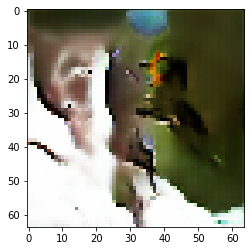

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.585871458053589 sec
Gen loss: 0.721726813775091, Disc loss: 1.4742256700184933, Disc valid real loss: 0.6846151051482534, Disc valid fake loss: 0.6825392414237749, Disc class real loss: 0.10707132716891596
Time for epoch 2 is 13.56335973739624 sec
Gen loss: 0.7279703917542124, Disc loss: 1.483989532400922, Disc valid real loss: 0.6910455986090146, Disc valid fake loss: 0.676685355543121, Disc class real loss: 0.11625857617194417
Time for epoch 3 is 13.624595642089844 sec
Gen loss: 0.7325928860563573, Disc loss: 1.481786144135121, Disc valid real loss: 0.6914410709042537, Disc valid fake loss: 0.6751051070244332, Disc class real loss: 0.11523996490622658
Time for epoch 4 is 13.591341018676758 sec
Gen loss: 0.7283413613714823, Disc loss: 1.491626922677203, Disc valid real loss: 0.6882507612065571, Disc valid fake loss: 0.67763291012627, Disc class re

Time for epoch 37 is 13.682904958724976 sec
Gen loss: 0.7106658523967919, Disc loss: 1.4807450561342523, Disc valid real loss: 0.6825990888484448, Disc valid fake loss: 0.6884457556212821, Disc class real loss: 0.10970021142081048
Time for epoch 38 is 13.567386627197266 sec
Gen loss: 0.7192148474173817, Disc loss: 1.4944566665949215, Disc valid real loss: 0.6915605741787733, Disc valid fake loss: 0.6819396434114554, Disc class real loss: 0.12095644820394306
Time for epoch 39 is 13.585811614990234 sec
Gen loss: 0.7223206606660755, Disc loss: 1.490020525487781, Disc valid real loss: 0.6950031835535354, Disc valid fake loss: 0.679261733361376, Disc class real loss: 0.11575561047810556
Time for epoch 40 is 13.57483172416687 sec
Gen loss: 0.7204186696670243, Disc loss: 1.490715223922316, Disc valid real loss: 0.6868802628866056, Disc valid fake loss: 0.6820641991891835, Disc class real loss: 0.1217707600492273
Time for epoch 41 is 13.568451404571533 sec
Gen loss: 0.7324748376843729, Disc lo

Time for epoch 73 is 13.50699520111084 sec
Gen loss: 0.7115519311692979, Disc loss: 1.4857748740410741, Disc valid real loss: 0.687394624480064, Disc valid fake loss: 0.6860125688356435, Disc class real loss: 0.11236767526520391
Time for epoch 74 is 13.670632362365723 sec
Gen loss: 0.7113018850000893, Disc loss: 1.4801235509112598, Disc valid real loss: 0.6901493011128289, Disc valid fake loss: 0.687283685052298, Disc class real loss: 0.10269057017001437
Time for epoch 75 is 13.48899221420288 sec
Gen loss: 0.7164422113720964, Disc loss: 1.4801655684706319, Disc valid real loss: 0.6899017651229693, Disc valid fake loss: 0.683482571507534, Disc class real loss: 0.10678123425464221
Time for epoch 76 is 13.60771131515503 sec
Gen loss: 0.7112648118802203, Disc loss: 1.4700092720145455, Disc valid real loss: 0.6877483131116645, Disc valid fake loss: 0.6858804618440023, Disc class real loss: 0.09638050046158188
Time for epoch 77 is 13.602691173553467 sec
Gen loss: 0.7176943830035243, Disc los

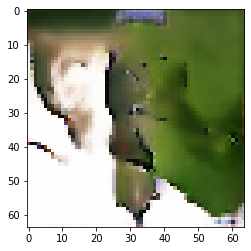

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.538667440414429 sec
Gen loss: 0.7119054001198228, Disc loss: 1.4685265035810187, Disc valid real loss: 0.6890939018590664, Disc valid fake loss: 0.6859108023850252, Disc class real loss: 0.09352180007848318
Time for epoch 2 is 13.684847354888916 sec
Gen loss: 0.7097518424677655, Disc loss: 1.4991594885745991, Disc valid real loss: 0.6857140185387154, Disc valid fake loss: 0.6889102572024999, Disc class real loss: 0.124535214567704
Time for epoch 3 is 13.550183057785034 sec
Gen loss: 0.715690006408588, Disc loss: 1.4965068379714883, Disc valid real loss: 0.6916373838900227, Disc valid fake loss: 0.6839645829627184, Disc class real loss: 0.1209048715640594
Time for epoch 4 is 13.662567377090454 sec
Gen loss: 0.7177496497547077, Disc loss: 1.488466471837465, Disc valid real loss: 0.6914638282483833, Disc valid fake loss: 0.68463640936668, Disc class r

Time for epoch 37 is 13.623478889465332 sec
Gen loss: 0.6980747805055241, Disc loss: 1.4891007253471105, Disc valid real loss: 0.686237742422719, Disc valid fake loss: 0.6925898468914394, Disc class real loss: 0.11027313594004079
Time for epoch 38 is 13.572754144668579 sec
Gen loss: 0.710819082046912, Disc loss: 1.4876237955842884, Disc valid real loss: 0.6901424187954849, Disc valid fake loss: 0.6849512683989879, Disc class real loss: 0.11253010813979089
Time for epoch 39 is 13.539222002029419 sec
Gen loss: 0.7026547639350581, Disc loss: 1.482319032596702, Disc valid real loss: 0.6892672872478723, Disc valid fake loss: 0.6907705861701552, Disc class real loss: 0.10228116117185297
Time for epoch 40 is 13.585380792617798 sec
Gen loss: 0.7087919175786378, Disc loss: 1.4721860087660916, Disc valid real loss: 0.6880144812873386, Disc valid fake loss: 0.6862233777033281, Disc class real loss: 0.09794815029535028
Time for epoch 41 is 13.570490837097168 sec
Gen loss: 0.7165161926894976, Disc 

Time for epoch 73 is 13.56794548034668 sec
Gen loss: 0.7037922236008373, Disc loss: 1.4856913238359983, Disc valid real loss: 0.6913882035227003, Disc valid fake loss: 0.6893629827473545, Disc class real loss: 0.10494013839410138
Time for epoch 74 is 13.554854154586792 sec
Gen loss: 0.7078450735668503, Disc loss: 1.4902610594664163, Disc valid real loss: 0.6925957561508427, Disc valid fake loss: 0.6865231184778497, Disc class real loss: 0.11114218523874936
Time for epoch 75 is 13.584343671798706 sec
Gen loss: 0.7013013734403988, Disc loss: 1.4903186585521957, Disc valid real loss: 0.6879121927711053, Disc valid fake loss: 0.6906713001773286, Disc class real loss: 0.11173516515166648
Time for epoch 76 is 13.569257974624634 sec
Gen loss: 0.6976703188929777, Disc loss: 1.4924867224241014, Disc valid real loss: 0.6834856940478813, Disc valid fake loss: 0.6942411031180281, Disc class real loss: 0.1147599201863171
Time for epoch 77 is 13.56009554862976 sec
Gen loss: 0.7065874551369892, Disc 

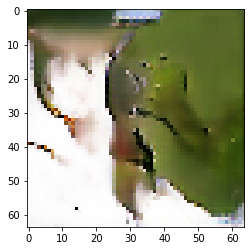

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.50264024734497 sec
Gen loss: 0.7024493923355247, Disc loss: 1.475416334340889, Disc valid real loss: 0.6867570061347672, Disc valid fake loss: 0.6925898045705263, Disc class real loss: 0.09606952362857585
Time for epoch 2 is 13.554324388504028 sec
Gen loss: 0.708113356980528, Disc loss: 1.4824398109906411, Disc valid real loss: 0.6931228742689944, Disc valid fake loss: 0.6873433056885634, Disc class real loss: 0.10197362580748659
Time for epoch 3 is 13.56826901435852 sec
Gen loss: 0.7077389034798475, Disc loss: 1.4797033384886538, Disc valid real loss: 0.6938732977158978, Disc valid fake loss: 0.6882931191100661, Disc class real loss: 0.09753692410141734
Time for epoch 4 is 13.562233924865723 sec
Gen loss: 0.7035007900015772, Disc loss: 1.4938125649118812, Disc valid real loss: 0.6889329437964008, Disc valid fake loss: 0.6907961971068447, Disc clas

Time for epoch 37 is 13.606637477874756 sec
Gen loss: 0.6987411161748375, Disc loss: 1.4806652237083207, Disc valid real loss: 0.6893362354456893, Disc valid fake loss: 0.6930625483918642, Disc class real loss: 0.09826644257162628
Time for epoch 38 is 13.479029893875122 sec
Gen loss: 0.7032656514547705, Disc loss: 1.4811051735063878, Disc valid real loss: 0.6900124352798875, Disc valid fake loss: 0.6900903055984476, Disc class real loss: 0.10100243118165539
Time for epoch 39 is 13.550675630569458 sec
Gen loss: 0.7066664049618936, Disc loss: 1.4848898174316902, Disc valid real loss: 0.697410146072305, Disc valid fake loss: 0.6864823897679647, Disc class real loss: 0.10099728365369118
Time for epoch 40 is 13.557579040527344 sec
Gen loss: 0.7041033088030207, Disc loss: 1.4692965325947376, Disc valid real loss: 0.6915816782612788, Disc valid fake loss: 0.6888685887098959, Disc class real loss: 0.0888462684763694
Time for epoch 41 is 13.54314637184143 sec
Gen loss: 0.6986492350495604, Disc 

Time for epoch 73 is 13.670242071151733 sec
Gen loss: 0.7072690739864256, Disc loss: 1.4901336321662757, Disc valid real loss: 0.6944276252736244, Disc valid fake loss: 0.6876255404658433, Disc class real loss: 0.10808046684778821
Time for epoch 74 is 13.460391283035278 sec
Gen loss: 0.7024425476547179, Disc loss: 1.4807215092304922, Disc valid real loss: 0.6900881338248731, Disc valid fake loss: 0.6900271566579659, Disc class real loss: 0.10060622091466614
Time for epoch 75 is 13.509994268417358 sec
Gen loss: 0.701838803485157, Disc loss: 1.4901400232702735, Disc valid real loss: 0.6935274076009508, Disc valid fake loss: 0.690320595816222, Disc class real loss: 0.10629202378491794
Time for epoch 76 is 13.538573026657104 sec
Gen loss: 0.6945499178516833, Disc loss: 1.4800226746535883, Disc valid real loss: 0.6863132130485886, Disc valid fake loss: 0.694833357644275, Disc class real loss: 0.09887610071217723
Time for epoch 77 is 13.533861875534058 sec
Gen loss: 0.7041850584309276, Disc 

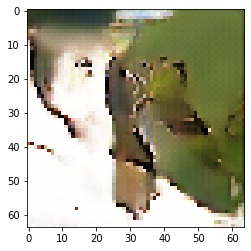

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.563306093215942 sec
Gen loss: 0.7007578469227324, Disc loss: 1.4703177798408156, Disc valid real loss: 0.6913673504581296, Disc valid fake loss: 0.6907731960136393, Disc class real loss: 0.0881772351741941
Time for epoch 2 is 13.499493837356567 sec
Gen loss: 0.7036194226283045, Disc loss: 1.479372586661238, Disc valid real loss: 0.6954194853299356, Disc valid fake loss: 0.6891569264212921, Disc class real loss: 0.09479617817366186
Time for epoch 3 is 13.489726543426514 sec
Gen loss: 0.6993470779925504, Disc loss: 1.4780944049519897, Disc valid real loss: 0.6872206412679781, Disc valid fake loss: 0.6919339914632038, Disc class real loss: 0.09893976991095764
Time for epoch 4 is 13.649044275283813 sec
Gen loss: 0.7089387687241159, Disc loss: 1.4757640759150188, Disc valid real loss: 0.6921997273840556, Disc valid fake loss: 0.6879780444349377, Disc cl

Time for epoch 37 is 13.573741674423218 sec
Gen loss: 0.704819534206132, Disc loss: 1.472299952817157, Disc valid real loss: 0.6952845719125536, Disc valid fake loss: 0.6875988648835882, Disc class real loss: 0.0894165147156808
Time for epoch 38 is 13.498656034469604 sec
Gen loss: 0.6898381656747523, Disc loss: 1.486583610214192, Disc valid real loss: 0.6867192335891207, Disc valid fake loss: 0.6979733093321162, Disc class real loss: 0.10189106748666524
Time for epoch 39 is 13.702353477478027 sec
Gen loss: 0.7014922066755734, Disc loss: 1.4756745316471833, Disc valid real loss: 0.6961353338830839, Disc valid fake loss: 0.6882999059630603, Disc class real loss: 0.09123929794656137
Time for epoch 40 is 13.559668064117432 sec
Gen loss: 0.7005947745912443, Disc loss: 1.4666639236899894, Disc valid real loss: 0.6940027937333435, Disc valid fake loss: 0.6899474145274175, Disc class real loss: 0.08271371536897015
Time for epoch 41 is 13.609830141067505 sec
Gen loss: 0.7005770115994503, Disc l

Time for epoch 73 is 13.556654930114746 sec
Gen loss: 0.6947629068925129, Disc loss: 1.4905810966724302, Disc valid real loss: 0.6900995388263609, Disc valid fake loss: 0.6951768761727868, Disc class real loss: 0.10530467902333539
Time for epoch 74 is 13.46507477760315 sec
Gen loss: 0.703595787690584, Disc loss: 1.4860493303314457, Disc valid real loss: 0.6900862276069517, Disc valid fake loss: 0.6917829371403227, Disc class real loss: 0.10418016752387463
Time for epoch 75 is 13.66974425315857 sec
Gen loss: 0.7065228265798512, Disc loss: 1.4750790957835955, Disc valid real loss: 0.6932732705178299, Disc valid fake loss: 0.6883701712781498, Disc class real loss: 0.09343565282283153
Time for epoch 76 is 13.552583694458008 sec
Gen loss: 0.7015701112385365, Disc loss: 1.479842091963543, Disc valid real loss: 0.6912648136699749, Disc valid fake loss: 0.691439119134815, Disc class real loss: 0.09713816073586136
Time for epoch 77 is 13.571945428848267 sec
Gen loss: 0.6995340395102979, Disc lo

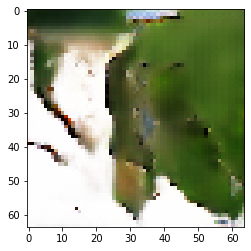

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.603852272033691 sec
Gen loss: 0.6959467606169745, Disc loss: 1.4659774267899635, Disc valid real loss: 0.6879215936673689, Disc valid fake loss: 0.6949129151458017, Disc class real loss: 0.08314291901187182
Time for epoch 2 is 13.507050275802612 sec
Gen loss: 0.7054059532922781, Disc loss: 1.485049220604625, Disc valid real loss: 0.6958642148066988, Disc valid fake loss: 0.687279102440449, Disc class real loss: 0.10190590467894113
Time for epoch 3 is 13.597412586212158 sec
Gen loss: 0.6992866490591509, Disc loss: 1.4768948432229723, Disc valid real loss: 0.6929348828346749, Disc valid fake loss: 0.6907973585090017, Disc class real loss: 0.09316260125383932
Time for epoch 4 is 13.596178531646729 sec
Gen loss: 0.7034845854531782, Disc loss: 1.4776681419310531, Disc valid real loss: 0.6940978981938143, Disc valid fake loss: 0.687806090849848, Disc cla

Time for epoch 37 is 13.568509101867676 sec
Gen loss: 0.6973864747902888, Disc loss: 1.467356461496534, Disc valid real loss: 0.6899798170014771, Disc valid fake loss: 0.6932771171980757, Disc class real loss: 0.08409952977368561
Time for epoch 38 is 13.518313884735107 sec
Gen loss: 0.7051806979709201, Disc loss: 1.4716062448858245, Disc valid real loss: 0.696716236066689, Disc valid fake loss: 0.6885735709169692, Disc class real loss: 0.08631643301339316
Time for epoch 39 is 13.61474871635437 sec
Gen loss: 0.7029444530081297, Disc loss: 1.4815795599283565, Disc valid real loss: 0.6891858747334985, Disc valid fake loss: 0.6912391533050434, Disc class real loss: 0.10115453575707488
Time for epoch 40 is 13.463996171951294 sec
Gen loss: 0.7094319067027187, Disc loss: 1.4670114707817554, Disc valid real loss: 0.6961726942036534, Disc valid fake loss: 0.6860815100876619, Disc class real loss: 0.08475726780429266
Time for epoch 41 is 13.588057518005371 sec
Gen loss: 0.7025503325591566, Disc 

Time for epoch 73 is 13.484166145324707 sec
Gen loss: 0.7027828247566533, Disc loss: 1.4775385552951636, Disc valid real loss: 0.6916741501025068, Disc valid fake loss: 0.6913364534455586, Disc class real loss: 0.09452795008210678
Time for epoch 74 is 13.652825355529785 sec
Gen loss: 0.7000934489697299, Disc loss: 1.4774482644347318, Disc valid real loss: 0.6934564057081373, Disc valid fake loss: 0.6909216952517749, Disc class real loss: 0.09307016780190447
Time for epoch 75 is 13.540722370147705 sec
Gen loss: 0.7065750547863927, Disc loss: 1.4678946151966001, Disc valid real loss: 0.6965897485492675, Disc valid fake loss: 0.6865458076562339, Disc class real loss: 0.08475906121269118
Time for epoch 76 is 13.621192693710327 sec
Gen loss: 0.7010063262489753, Disc loss: 1.4627012624973204, Disc valid real loss: 0.6916572479051626, Disc valid fake loss: 0.691119894910311, Disc class real loss: 0.07992412240206904
Time for epoch 77 is 13.546302318572998 sec
Gen loss: 0.6979221659624156, Dis

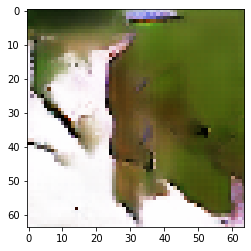

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.655269384384155 sec
Gen loss: 0.7017426474630671, Disc loss: 1.4723760555107095, Disc valid real loss: 0.6943502430993367, Disc valid fake loss: 0.6885278625539971, Disc class real loss: 0.08949794798246603
Time for epoch 2 is 13.705369710922241 sec
Gen loss: 0.6929281547786744, Disc loss: 1.4673376593809464, Disc valid real loss: 0.6897613230113414, Disc valid fake loss: 0.69481355339531, Disc class real loss: 0.08276277911066277
Time for epoch 3 is 13.656756401062012 sec
Gen loss: 0.7004492739997905, Disc loss: 1.471320657872249, Disc valid real loss: 0.6931977322108054, Disc valid fake loss: 0.6899710984087895, Disc class real loss: 0.08815182944218505
Time for epoch 4 is 13.716990232467651 sec
Gen loss: 0.7024654062782846, Disc loss: 1.473274547233168, Disc valid real loss: 0.6910126021883998, Disc valid fake loss: 0.6908041177403313, Disc clas

Time for epoch 37 is 13.527403831481934 sec
Gen loss: 0.6907404771019127, Disc loss: 1.4931812997109846, Disc valid real loss: 0.6877441025038722, Disc valid fake loss: 0.6963413692102199, Disc class real loss: 0.10909583133397381
Time for epoch 38 is 13.561895847320557 sec
Gen loss: 0.7021050848935032, Disc loss: 1.465431568745352, Disc valid real loss: 0.6949831349093739, Disc valid fake loss: 0.689709900678981, Disc class real loss: 0.08073853273130432
Time for epoch 39 is 13.546719074249268 sec
Gen loss: 0.7026111171820623, Disc loss: 1.4736119825342484, Disc valid real loss: 0.6950585993970959, Disc valid fake loss: 0.6891047345590462, Disc class real loss: 0.08944864876909518
Time for epoch 40 is 13.573925018310547 sec
Gen loss: 0.6959550563235916, Disc loss: 1.4911573879764008, Disc valid real loss: 0.6929444804747253, Disc valid fake loss: 0.6932941557269109, Disc class real loss: 0.10491875592911955
Time for epoch 41 is 13.537431955337524 sec
Gen loss: 0.6930398343378289, Disc

Time for epoch 73 is 13.585794925689697 sec
Gen loss: 0.7013862548158744, Disc loss: 1.4559475299788684, Disc valid real loss: 0.690251641318727, Disc valid fake loss: 0.690594252855151, Disc class real loss: 0.07510163691543172
Time for epoch 74 is 13.501448154449463 sec
Gen loss: 0.7039822046026628, Disc loss: 1.4659417279690585, Disc valid real loss: 0.6977160156257753, Disc valid fake loss: 0.6890655797994557, Disc class real loss: 0.07916013063488435
Time for epoch 75 is 13.594265699386597 sec
Gen loss: 0.7049938173798042, Disc loss: 1.4685217416706446, Disc valid real loss: 0.6931471593657806, Disc valid fake loss: 0.6887943314989085, Disc class real loss: 0.0865802516403837
Time for epoch 76 is 13.48230266571045 sec
Gen loss: 0.7050031087585904, Disc loss: 1.475188717932559, Disc valid real loss: 0.6941951833120207, Disc valid fake loss: 0.6901221281790798, Disc class real loss: 0.09087140506663774
Time for epoch 77 is 13.57558298110962 sec
Gen loss: 0.6962683827573368, Disc los

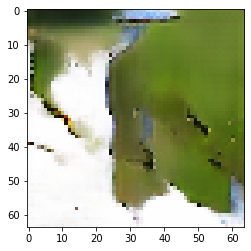

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 19

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.577276229858398 sec
Gen loss: 0.702423510997276, Disc loss: 1.4650511279661804, Disc valid real loss: 0.6923254138732021, Disc valid fake loss: 0.6908433734562985, Disc class real loss: 0.08188234212034418
Time for epoch 2 is 13.581665754318237 sec
Gen loss: 0.6943002377099138, Disc loss: 1.4813995060881948, Disc valid real loss: 0.6899995937903076, Disc valid fake loss: 0.6953247276748099, Disc class real loss: 0.09607518502027755
Time for epoch 3 is 13.588991403579712 sec
Gen loss: 0.6953907933661608, Disc loss: 1.4710709719153923, Disc valid real loss: 0.6909123113161826, Disc valid fake loss: 0.6937260999266048, Disc class real loss: 0.08643256524301053
Time for epoch 4 is 13.573286771774292 sec
Gen loss: 0.7037619481564861, Disc loss: 1.475879492152351, Disc valid real loss: 0.6973052490048293, Disc valid fake loss: 0.686830892957, Disc class 

Time for epoch 37 is 13.633555173873901 sec
Gen loss: 0.6935153223957796, Disc loss: 1.4586504235823303, Disc valid real loss: 0.6886999114419063, Disc valid fake loss: 0.6956732441093217, Disc class real loss: 0.07427726545434844
Time for epoch 38 is 13.512665748596191 sec
Gen loss: 0.6981584615500639, Disc loss: 1.4580236162919662, Disc valid real loss: 0.6927131139812107, Disc valid fake loss: 0.6918552516275628, Disc class real loss: 0.07345525030594706
Time for epoch 39 is 13.517074823379517 sec
Gen loss: 0.6931474743496758, Disc loss: 1.4678923686345418, Disc valid real loss: 0.6894055440173885, Disc valid fake loss: 0.6953337310452449, Disc class real loss: 0.08315309061881611
Time for epoch 40 is 13.53224229812622 sec
Gen loss: 0.6994408120307819, Disc loss: 1.4569596934124707, Disc valid real loss: 0.6952136817986403, Disc valid fake loss: 0.6895822039464625, Disc class real loss: 0.07216381018031401
Time for epoch 41 is 13.582890510559082 sec
Gen loss: 0.6967261320530238, Dis

Time for epoch 73 is 13.692371368408203 sec
Gen loss: 0.7019589003831713, Disc loss: 1.447990617131799, Disc valid real loss: 0.6957954496226013, Disc valid fake loss: 0.6894668521596811, Disc class real loss: 0.06272831341647828
Time for epoch 74 is 13.526281595230103 sec
Gen loss: 0.7013551268151136, Disc loss: 1.471432500415378, Disc valid real loss: 0.6953927856796802, Disc valid fake loss: 0.6886701087964583, Disc class real loss: 0.08736960083550047
Time for epoch 75 is 13.615781784057617 sec
Gen loss: 0.6908166707369693, Disc loss: 1.4625415294797117, Disc valid real loss: 0.6875842924363568, Disc valid fake loss: 0.6963746938602065, Disc class real loss: 0.0785825433442448
Time for epoch 76 is 13.537102222442627 sec
Gen loss: 0.6946197691648633, Disc loss: 1.4673552038223763, Disc valid real loss: 0.6912754438110806, Disc valid fake loss: 0.6934073010111242, Disc class real loss: 0.08267245889057848
Time for epoch 77 is 13.49405288696289 sec
Gen loss: 0.7015874316375753, Disc l

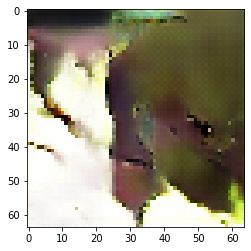

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.527305364608765 sec
Gen loss: 0.701726312075204, Disc loss: 1.4521583825915163, Disc valid real loss: 0.688817620438935, Disc valid fake loss: 0.693395369582706, Disc class real loss: 0.06994539227016108
Time for epoch 2 is 13.61734676361084 sec
Gen loss: 0.6945695775311168, Disc loss: 1.4662387374293837, Disc valid real loss: 0.690297407671042, Disc valid fake loss: 0.6967696671886496, Disc class real loss: 0.07917166417787595
Time for epoch 3 is 13.564095735549927 sec
Gen loss: 0.6975844457220579, Disc loss: 1.4609037466488557, Disc valid real loss: 0.6912250011593992, Disc valid fake loss: 0.6928878904681218, Disc class real loss: 0.07679084977041993
Time for epoch 4 is 13.512049674987793 sec
Gen loss: 0.6978153174485617, Disc loss: 1.4629965852592697, Disc valid real loss: 0.6922519328148384, Disc valid fake loss: 0.6911036254267705, Disc class

Time for epoch 37 is 13.557045221328735 sec
Gen loss: 0.6956693171485653, Disc loss: 1.4667242009465287, Disc valid real loss: 0.6912063169608594, Disc valid fake loss: 0.6945979155822175, Disc class real loss: 0.08091997292355668
Time for epoch 38 is 13.57119607925415 sec
Gen loss: 0.6953779517150507, Disc loss: 1.4756740389800653, Disc valid real loss: 0.6913547601480148, Disc valid fake loss: 0.6933756299458222, Disc class real loss: 0.09094365066006341
Time for epoch 39 is 13.554058313369751 sec
Gen loss: 0.7013755418097747, Disc loss: 1.4660874799015076, Disc valid real loss: 0.6956289909719452, Disc valid fake loss: 0.689668301644364, Disc class real loss: 0.08079019017570568
Time for epoch 40 is 13.54003119468689 sec
Gen loss: 0.6987687205557578, Disc loss: 1.4634290568550752, Disc valid real loss: 0.6925258670395952, Disc valid fake loss: 0.6909410026338365, Disc class real loss: 0.07996219298146888
Time for epoch 41 is 13.55229139328003 sec
Gen loss: 0.6966724765656117, Disc l

Time for epoch 73 is 13.497609853744507 sec
Gen loss: 0.6923506271225327, Disc loss: 1.4465689252062541, Disc valid real loss: 0.6864980475366277, Disc valid fake loss: 0.6966055344113813, Disc class real loss: 0.06346533771290074
Time for epoch 74 is 13.561235666275024 sec
Gen loss: 0.7042138600737099, Disc loss: 1.460345994489303, Disc valid real loss: 0.6969229444901794, Disc valid fake loss: 0.6885850456995046, Disc class real loss: 0.07483800676086416
Time for epoch 75 is 13.576211214065552 sec
Gen loss: 0.6980487384447237, Disc loss: 1.4589540396279437, Disc valid real loss: 0.6944445431393983, Disc valid fake loss: 0.6900063963117316, Disc class real loss: 0.07450310112793329
Time for epoch 76 is 13.538664817810059 sec
Gen loss: 0.6999797662745323, Disc loss: 1.4486462808236844, Disc valid real loss: 0.6944726069122149, Disc valid fake loss: 0.6886397096199718, Disc class real loss: 0.06553396490924417
Time for epoch 77 is 13.607455253601074 sec
Gen loss: 0.6912881580148609, Dis

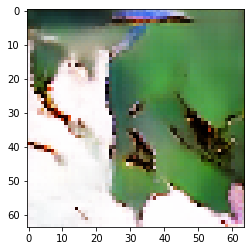

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 21

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.582405805587769 sec
Gen loss: 0.6981279764395096, Disc loss: 1.4597476630353023, Disc valid real loss: 0.6948687602187883, Disc valid fake loss: 0.6931543909114227, Disc class real loss: 0.07172450691486881
Time for epoch 2 is 13.600101232528687 sec
Gen loss: 0.7039926809670156, Disc loss: 1.4625268945202918, Disc valid real loss: 0.6940225647070867, Disc valid fake loss: 0.6885894435208019, Disc class real loss: 0.07991488438878407
Time for epoch 3 is 13.54436993598938 sec
Gen loss: 0.7010040360737623, Disc loss: 1.4710457993716728, Disc valid real loss: 0.6952401039400075, Disc valid fake loss: 0.6898655295372009, Disc class real loss: 0.08594016526695744
Time for epoch 4 is 13.569030284881592 sec
Gen loss: 0.6970437792581594, Disc loss: 1.4617786814526814, Disc valid real loss: 0.6913995681416375, Disc valid fake loss: 0.6936638613703451, Disc c

Time for epoch 37 is 13.55124568939209 sec
Gen loss: 0.6958844091511032, Disc loss: 1.4612604896550578, Disc valid real loss: 0.6926970276729201, Disc valid fake loss: 0.6929950806183544, Disc class real loss: 0.07556838026696733
Time for epoch 38 is 13.520049095153809 sec
Gen loss: 0.6939931658871452, Disc loss: 1.4541359600335926, Disc valid real loss: 0.6899310983616486, Disc valid fake loss: 0.694862764056136, Disc class real loss: 0.06934209867017116
Time for epoch 39 is 13.542702674865723 sec
Gen loss: 0.7108333995994837, Disc loss: 1.4605102257999947, Disc valid real loss: 0.6977288726222547, Disc valid fake loss: 0.6850660522455768, Disc class real loss: 0.0777153033725075
Time for epoch 40 is 13.604922533035278 sec
Gen loss: 0.6895018520393992, Disc loss: 1.4645056123655986, Disc valid real loss: 0.6870317060126845, Disc valid fake loss: 0.6980298770475517, Disc class real loss: 0.07944402872612523
Time for epoch 41 is 13.480525970458984 sec
Gen loss: 0.6936619674287191, Disc 

Time for epoch 73 is 13.556973457336426 sec
Gen loss: 0.692549903056809, Disc loss: 1.4599330483413324, Disc valid real loss: 0.6912404113022615, Disc valid fake loss: 0.6953730321511989, Disc class real loss: 0.07331960493058116
Time for epoch 74 is 13.554060220718384 sec
Gen loss: 0.7000321238667662, Disc loss: 1.4532984430550884, Disc valid real loss: 0.692615940157314, Disc valid fake loss: 0.6910979255105099, Disc class real loss: 0.06958457683902398
Time for epoch 75 is 13.586877346038818 sec
Gen loss: 0.6969786546417691, Disc loss: 1.4563383529502847, Disc valid real loss: 0.691252174739269, Disc valid fake loss: 0.6926454898464648, Disc class real loss: 0.07244068564302736
Time for epoch 76 is 13.548774242401123 sec
Gen loss: 0.6995870280395032, Disc loss: 1.468992631609847, Disc valid real loss: 0.6953680088849572, Disc valid fake loss: 0.6891611833882526, Disc class real loss: 0.08446344104279993
Time for epoch 77 is 13.533532857894897 sec
Gen loss: 0.7033036396432375, Disc l

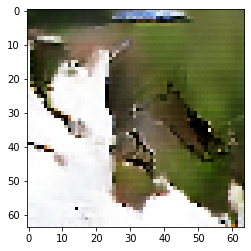

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 22

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.580430507659912 sec
Gen loss: 0.697477495928767, Disc loss: 1.460368916594239, Disc valid real loss: 0.6930248002372783, Disc valid fake loss: 0.6919311496623486, Disc class real loss: 0.07541296616169264
Time for epoch 2 is 13.581512689590454 sec
Gen loss: 0.69917417525599, Disc loss: 1.4617927504102712, Disc valid real loss: 0.6954224815536644, Disc valid fake loss: 0.689441233631072, Disc class real loss: 0.07692903444552851
Time for epoch 3 is 13.62299633026123 sec
Gen loss: 0.6939860616273027, Disc loss: 1.4504451018361864, Disc valid real loss: 0.6919380838308877, Disc valid fake loss: 0.6928000101229039, Disc class real loss: 0.06570700711863611
Time for epoch 4 is 13.58470630645752 sec
Gen loss: 0.6935269020114164, Disc loss: 1.4572697561284713, Disc valid real loss: 0.691691312201947, Disc valid fake loss: 0.6923968334831196, Disc class re

Time for epoch 37 is 13.615938901901245 sec
Gen loss: 0.7036389496914417, Disc loss: 1.4484873525495452, Disc valid real loss: 0.6955633386363828, Disc valid fake loss: 0.6886053032022181, Disc class real loss: 0.06431871283599705
Time for epoch 38 is 13.529131650924683 sec
Gen loss: 0.6955647156813604, Disc loss: 1.4484479650249327, Disc valid real loss: 0.6908513818006852, Disc valid fake loss: 0.6933736390860746, Disc class real loss: 0.06422294236511662
Time for epoch 39 is 13.698991060256958 sec
Gen loss: 0.7002287820425783, Disc loss: 1.4540064638546166, Disc valid real loss: 0.6930673448697016, Disc valid fake loss: 0.6896042799561973, Disc class real loss: 0.07133483575599592
Time for epoch 40 is 13.605914831161499 sec
Gen loss: 0.691507405543392, Disc loss: 1.4553252251813729, Disc valid real loss: 0.6905183593432108, Disc valid fake loss: 0.6960758855995447, Disc class real loss: 0.06873097947406004
Time for epoch 41 is 13.619003534317017 sec
Gen loss: 0.6989762119161405, Dis

Time for epoch 73 is 13.563267946243286 sec
Gen loss: 0.689752057800448, Disc loss: 1.4594077863667392, Disc valid real loss: 0.6894138692840328, Disc valid fake loss: 0.6956398608238716, Disc class real loss: 0.07435405670379706
Time for epoch 74 is 13.54840612411499 sec
Gen loss: 0.6930381418243656, Disc loss: 1.4541887448732123, Disc valid real loss: 0.6895898593473564, Disc valid fake loss: 0.6934277752873698, Disc class real loss: 0.07117110835202164
Time for epoch 75 is 13.570184707641602 sec
Gen loss: 0.7031629812426683, Disc loss: 1.4589054006225048, Disc valid real loss: 0.6983634609840104, Disc valid fake loss: 0.6872298964639989, Disc class real loss: 0.07331204657605501
Time for epoch 76 is 13.620473623275757 sec
Gen loss: 0.6923574824643329, Disc loss: 1.4540089956790128, Disc valid real loss: 0.6895388319563414, Disc valid fake loss: 0.6952073215469112, Disc class real loss: 0.06926284384703686
Time for epoch 77 is 13.53827977180481 sec
Gen loss: 0.6932369562668529, Disc 

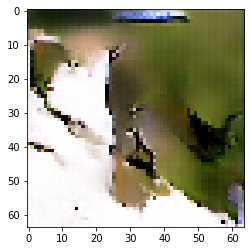

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 23

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.551619291305542 sec
Gen loss: 0.6991901173178097, Disc loss: 1.4590334417374153, Disc valid real loss: 0.6943597423674938, Disc valid fake loss: 0.6895482981108069, Disc class real loss: 0.07512540052233038
Time for epoch 2 is 13.556028366088867 sec
Gen loss: 0.693753842900439, Disc loss: 1.4519204841396673, Disc valid real loss: 0.6908032097790623, Disc valid fake loss: 0.693596135148511, Disc class real loss: 0.0675211388892308
Time for epoch 3 is 13.554572343826294 sec
Gen loss: 0.6946875533760402, Disc loss: 1.4494897259606256, Disc valid real loss: 0.6922911636551544, Disc valid fake loss: 0.6925683674127429, Disc class real loss: 0.06463019632607217
Time for epoch 4 is 13.55768895149231 sec
Gen loss: 0.6990228657153886, Disc loss: 1.459430503005258, Disc valid real loss: 0.6952210727745924, Disc valid fake loss: 0.690220965117943, Disc class 

Time for epoch 37 is 13.646095275878906 sec
Gen loss: 0.6962933341662089, Disc loss: 1.4616762367367422, Disc valid real loss: 0.6909291075497139, Disc valid fake loss: 0.6921790473183319, Disc class real loss: 0.07856807868056495
Time for epoch 38 is 13.537636041641235 sec
Gen loss: 0.7023319312873572, Disc loss: 1.4567628349392072, Disc valid real loss: 0.6979097026150402, Disc valid fake loss: 0.6886940477340202, Disc class real loss: 0.07015907947501063
Time for epoch 39 is 13.590683937072754 sec
Gen loss: 0.7018395470086798, Disc loss: 1.45898007861967, Disc valid real loss: 0.6939651571961276, Disc valid fake loss: 0.6888975318531357, Disc class real loss: 0.07611738623409431
Time for epoch 40 is 13.571072340011597 sec
Gen loss: 0.6921836370375098, Disc loss: 1.4579831920665132, Disc valid real loss: 0.6884272184152267, Disc valid fake loss: 0.6955910140905923, Disc class real loss: 0.07396495528661123
Time for epoch 41 is 13.60270094871521 sec
Gen loss: 0.6949490920961064, Disc 

Time for epoch 73 is 13.563809156417847 sec
Gen loss: 0.7005418325827374, Disc loss: 1.4604094128621625, Disc valid real loss: 0.6948295511850496, Disc valid fake loss: 0.6894635201146609, Disc class real loss: 0.07611633872037228
Time for epoch 74 is 13.607537984848022 sec
Gen loss: 0.6918220408563691, Disc loss: 1.448821390870464, Disc valid real loss: 0.6901972489305305, Disc valid fake loss: 0.6948615483798308, Disc class real loss: 0.06376259473267533
Time for epoch 75 is 13.595278978347778 sec
Gen loss: 0.6996322909021765, Disc loss: 1.4538669091899221, Disc valid real loss: 0.6937671371591769, Disc valid fake loss: 0.6899547962961481, Disc class real loss: 0.07014497400053318
Time for epoch 76 is 13.605496644973755 sec
Gen loss: 0.697561181173092, Disc loss: 1.4629140707858532, Disc valid real loss: 0.6921796076666049, Disc valid fake loss: 0.691441420294082, Disc class real loss: 0.07929304602410332
Time for epoch 77 is 13.596421241760254 sec
Gen loss: 0.694163758095687, Disc l

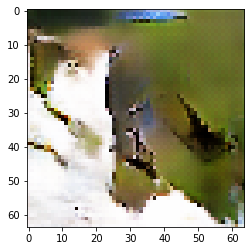

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 24

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.649137496948242 sec
Gen loss: 0.6987350741376076, Disc loss: 1.451697877429042, Disc valid real loss: 0.6940063008771034, Disc valid fake loss: 0.6910133303665533, Disc class real loss: 0.06667824221129288
Time for epoch 2 is 13.466222524642944 sec
Gen loss: 0.6981880475835103, Disc loss: 1.4570475807034873, Disc valid real loss: 0.6930521970518883, Disc valid fake loss: 0.690234161327848, Disc class real loss: 0.0737612212889482
Time for epoch 3 is 13.700340270996094 sec
Gen loss: 0.6984032407039549, Disc loss: 1.459273701760827, Disc valid real loss: 0.6947485702793773, Disc valid fake loss: 0.6897059666108956, Disc class real loss: 0.0748191660849687
Time for epoch 4 is 13.54306173324585 sec
Gen loss: 0.6947256879108709, Disc loss: 1.4575779648008063, Disc valid real loss: 0.6916919055023814, Disc valid fake loss: 0.692128055140901, Disc class r

Time for epoch 37 is 13.594077348709106 sec
Gen loss: 0.6950283564203154, Disc loss: 1.4521552660277866, Disc valid real loss: 0.6923598207755464, Disc valid fake loss: 0.6919877365998782, Disc class real loss: 0.06780770806599666
Time for epoch 38 is 13.60926103591919 sec
Gen loss: 0.6919191878662523, Disc loss: 1.4595628876673175, Disc valid real loss: 0.6904542541439295, Disc valid fake loss: 0.6948515162235354, Disc class real loss: 0.07425711873986128
Time for epoch 39 is 13.639052629470825 sec
Gen loss: 0.7054242814782512, Disc loss: 1.4592811880395988, Disc valid real loss: 0.696748403675834, Disc valid fake loss: 0.6860224764521529, Disc class real loss: 0.07651030861044883
Time for epoch 40 is 13.590674638748169 sec
Gen loss: 0.6935481227187283, Disc loss: 1.4452090308595156, Disc valid real loss: 0.692356400858096, Disc valid fake loss: 0.6931335024717378, Disc class real loss: 0.059719124315788845
Time for epoch 41 is 13.589757204055786 sec
Gen loss: 0.6968284517445862, Disc

Time for epoch 73 is 13.70000433921814 sec
Gen loss: 0.6939301439094027, Disc loss: 1.4583467009267832, Disc valid real loss: 0.6908434018856142, Disc valid fake loss: 0.692766059381852, Disc class real loss: 0.07473724178421225
Time for epoch 74 is 13.607528448104858 sec
Gen loss: 0.6992253575544694, Disc loss: 1.4646823955422172, Disc valid real loss: 0.695529324252431, Disc valid fake loss: 0.6895480676072077, Disc class real loss: 0.07960501011704892
Time for epoch 75 is 13.580627202987671 sec
Gen loss: 0.6984485077664135, Disc loss: 1.4733367570370517, Disc valid real loss: 0.6925997798681905, Disc valid fake loss: 0.6910958774690705, Disc class real loss: 0.0896411006721661
Time for epoch 76 is 13.560288667678833 sec
Gen loss: 0.6945816607979255, Disc loss: 1.4509525618902066, Disc valid real loss: 0.6914498017732367, Disc valid fake loss: 0.6926712216077459, Disc class real loss: 0.0668315425350963
Time for epoch 77 is 13.538904666900635 sec
Gen loss: 0.6967251757942241, Disc lo

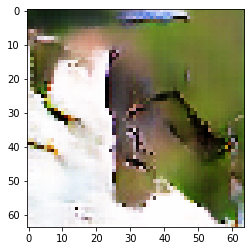

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 25

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.676527976989746 sec
Gen loss: 0.6962576245227803, Disc loss: 1.4610807837509527, Disc valid real loss: 0.693982673369772, Disc valid fake loss: 0.690176198314522, Disc class real loss: 0.07692191020967752
Time for epoch 2 is 13.482927560806274 sec
Gen loss: 0.6956298440129454, Disc loss: 1.4583615726894803, Disc valid real loss: 0.6930494888365107, Disc valid fake loss: 0.6914268481699108, Disc class real loss: 0.0738852396512358
Time for epoch 3 is 13.62009334564209 sec
Gen loss: 0.6958435297335389, Disc loss: 1.4616229815211723, Disc valid real loss: 0.6941880105633723, Disc valid fake loss: 0.6912026415026284, Disc class real loss: 0.07623232842052638
Time for epoch 4 is 13.600857019424438 sec
Gen loss: 0.6965613250486896, Disc loss: 1.4541299524022957, Disc valid real loss: 0.6932060742765908, Disc valid fake loss: 0.6914003481709861, Disc clas

Time for epoch 37 is 13.587771892547607 sec
Gen loss: 0.692978043543291, Disc loss: 1.4458942668547798, Disc valid real loss: 0.6929053922655782, Disc valid fake loss: 0.6930480623632912, Disc class real loss: 0.059940807818632154
Time for epoch 38 is 13.578071594238281 sec
Gen loss: 0.6945459446932888, Disc loss: 1.4532310536237267, Disc valid real loss: 0.693676711582556, Disc valid fake loss: 0.6916284389935212, Disc class real loss: 0.06792590329589228
Time for epoch 39 is 13.622436761856079 sec
Gen loss: 0.6936029778909554, Disc loss: 1.4562872438249872, Disc valid real loss: 0.6922041263360641, Disc valid fake loss: 0.6924736435174296, Disc class real loss: 0.07160947074031765
Time for epoch 40 is 13.532730102539062 sec
Gen loss: 0.698319374545803, Disc loss: 1.4533239829184885, Disc valid real loss: 0.6941066557152807, Disc valid fake loss: 0.6900156406852288, Disc class real loss: 0.0692016863230465
Time for epoch 41 is 13.56320858001709 sec
Gen loss: 0.6918025328537959, Disc l

Time for epoch 73 is 13.565083026885986 sec
Gen loss: 0.6964496747265018, Disc loss: 1.4481156602461487, Disc valid real loss: 0.6935500672193078, Disc valid fake loss: 0.6911091990264128, Disc class real loss: 0.06345639868112662
Time for epoch 74 is 13.555353879928589 sec
Gen loss: 0.6982249005377131, Disc loss: 1.4587196014760955, Disc valid real loss: 0.6941696831850501, Disc valid fake loss: 0.6908784166261109, Disc class real loss: 0.07367150145540066
Time for epoch 75 is 13.565889596939087 sec
Gen loss: 0.6923424851926685, Disc loss: 1.4651948788624791, Disc valid real loss: 0.6913182758057344, Disc valid fake loss: 0.6939259706150872, Disc class real loss: 0.07995063654711182
Time for epoch 76 is 13.583176612854004 sec
Gen loss: 0.6996888794550081, Disc loss: 1.4567126355520108, Disc valid real loss: 0.6956739369123609, Disc valid fake loss: 0.6885579011950712, Disc class real loss: 0.0724807994591317
Time for epoch 77 is 13.570010423660278 sec
Gen loss: 0.6929170826909342, Dis

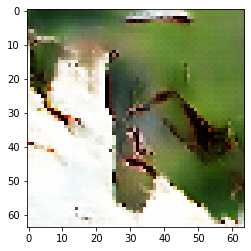

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 26

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.618671417236328 sec
Gen loss: 0.6985975941668358, Disc loss: 1.457650220814113, Disc valid real loss: 0.6955766954073092, Disc valid fake loss: 0.689757355344974, Disc class real loss: 0.07231617004432031
Time for epoch 2 is 13.533844947814941 sec
Gen loss: 0.6952684287456316, Disc loss: 1.451989989939744, Disc valid real loss: 0.6907496544403758, Disc valid fake loss: 0.692639604978122, Disc class real loss: 0.06860072839629176
Time for epoch 3 is 13.564819812774658 sec
Gen loss: 0.694508177478139, Disc loss: 1.4513498357317958, Disc valid real loss: 0.6928354957239414, Disc valid fake loss: 0.6926719859686647, Disc class real loss: 0.06584235650960399
Time for epoch 4 is 13.622054100036621 sec
Gen loss: 0.6999870994226719, Disc loss: 1.4590706528040776, Disc valid real loss: 0.6954721406223329, Disc valid fake loss: 0.6886045420719032, Disc class

Time for epoch 37 is 13.587064266204834 sec
Gen loss: 0.6932974942331391, Disc loss: 1.4479509272226474, Disc valid real loss: 0.6921501397117367, Disc valid fake loss: 0.6925896617778271, Disc class real loss: 0.06321112460761709
Time for epoch 38 is 13.540132761001587 sec
Gen loss: 0.6905865528719212, Disc loss: 1.4464565263531073, Disc valid real loss: 0.6887836966734269, Disc valid fake loss: 0.6954145362060568, Disc class real loss: 0.062258294470252364
Time for epoch 39 is 13.652723550796509 sec
Gen loss: 0.6987582256154317, Disc loss: 1.4500672859228076, Disc valid real loss: 0.693657426168602, Disc valid fake loss: 0.691184510706563, Disc class real loss: 0.0652253503128805
Time for epoch 40 is 13.582794189453125 sec
Gen loss: 0.7019561244866389, Disc loss: 1.450011623584158, Disc valid real loss: 0.6962817325824644, Disc valid fake loss: 0.687993840311924, Disc class real loss: 0.06573604938388312
Time for epoch 41 is 13.658397436141968 sec
Gen loss: 0.6961584724384918, Disc l

Time for epoch 73 is 13.626009702682495 sec
Gen loss: 0.6983101763699436, Disc loss: 1.4542575370328537, Disc valid real loss: 0.6937313734031305, Disc valid fake loss: 0.6905346507948589, Disc class real loss: 0.06999151077908582
Time for epoch 74 is 13.54084587097168 sec
Gen loss: 0.6951385234106524, Disc loss: 1.445065755831194, Disc valid real loss: 0.6916755588074041, Disc valid fake loss: 0.6924070197392286, Disc class real loss: 0.0609831743834062
Time for epoch 75 is 13.595385789871216 sec
Gen loss: 0.6973917855802914, Disc loss: 1.4568832418136803, Disc valid real loss: 0.6959673337497039, Disc valid fake loss: 0.6903612051552873, Disc class real loss: 0.07055470736076178
Time for epoch 76 is 13.5829176902771 sec
Gen loss: 0.6938625680721873, Disc loss: 1.4542136964436145, Disc valid real loss: 0.6913845288721203, Disc valid fake loss: 0.6926729462657194, Disc class real loss: 0.07015622005695231
Time for epoch 77 is 13.576303720474243 sec
Gen loss: 0.6959376919883377, Disc lo

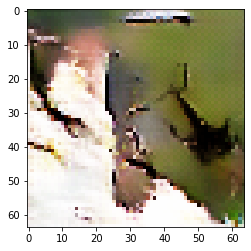

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 27

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.560800313949585 sec
Gen loss: 0.6961646545224074, Disc loss: 1.4436015998767966, Disc valid real loss: 0.6931387226432966, Disc valid fake loss: 0.691052066762919, Disc class real loss: 0.05941081109059518
Time for epoch 2 is 13.504822969436646 sec
Gen loss: 0.6922016920759103, Disc loss: 1.4470629579006495, Disc valid real loss: 0.6919119267605831, Disc valid fake loss: 0.693113613904007, Disc class real loss: 0.06203741401375658
Time for epoch 3 is 13.644911289215088 sec
Gen loss: 0.6950433341468253, Disc loss: 1.453094600338923, Disc valid real loss: 0.6946676081112084, Disc valid fake loss: 0.6908324349540359, Disc class real loss: 0.06759455686634334
Time for epoch 4 is 13.58086633682251 sec
Gen loss: 0.6926095438843497, Disc loss: 1.4395360891735005, Disc valid real loss: 0.6919829549828196, Disc valid fake loss: 0.692630621475902, Disc class

Time for epoch 37 is 13.678407430648804 sec
Gen loss: 0.6977132245454039, Disc loss: 1.446518254150866, Disc valid real loss: 0.6929539765122783, Disc valid fake loss: 0.6908111333200925, Disc class real loss: 0.06275314485817816
Time for epoch 38 is 13.59635877609253 sec
Gen loss: 0.6922975419982662, Disc loss: 1.448657186696846, Disc valid real loss: 0.6905106297999539, Disc valid fake loss: 0.6943838160212447, Disc class real loss: 0.06376274496302003
Time for epoch 39 is 13.525270223617554 sec
Gen loss: 0.6956686141691234, Disc loss: 1.4485589081678933, Disc valid real loss: 0.6924344604900536, Disc valid fake loss: 0.6914997454581222, Disc class real loss: 0.06462470357867517
Time for epoch 40 is 13.657146453857422 sec
Gen loss: 0.6974320290534477, Disc loss: 1.4451360760665521, Disc valid real loss: 0.6947473507263473, Disc valid fake loss: 0.6907197023794903, Disc class real loss: 0.059669024986901124
Time for epoch 41 is 13.628767013549805 sec
Gen loss: 0.6951510607388608, Disc

Time for epoch 73 is 13.69811224937439 sec
Gen loss: 0.700777253322808, Disc loss: 1.4370132978692611, Disc valid real loss: 0.6972802166693256, Disc valid fake loss: 0.6879076608797399, Disc class real loss: 0.05182542092766901
Time for epoch 74 is 13.625144720077515 sec
Gen loss: 0.6937441071520652, Disc loss: 1.4518921349429825, Disc valid real loss: 0.6924508162307222, Disc valid fake loss: 0.6920540518553923, Disc class real loss: 0.06738726337129003
Time for epoch 75 is 13.549295663833618 sec
Gen loss: 0.695535781745342, Disc loss: 1.4535092748600615, Disc valid real loss: 0.6918459932009379, Disc valid fake loss: 0.6908099328276265, Disc class real loss: 0.0708533482151901
Time for epoch 76 is 13.64607858657837 sec
Gen loss: 0.692720164613026, Disc loss: 1.4543436164778423, Disc valid real loss: 0.6914489978374181, Disc valid fake loss: 0.6935770965527067, Disc class real loss: 0.06931752148982696
Time for epoch 77 is 13.616525173187256 sec
Gen loss: 0.6950423221601058, Disc los

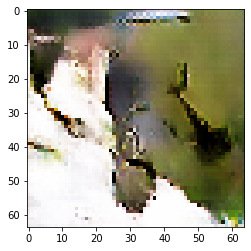

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 28

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.64890193939209 sec
Gen loss: 0.6904247811816249, Disc loss: 1.4436397642947147, Disc valid real loss: 0.6902617613474528, Disc valid fake loss: 0.6945415517178978, Disc class real loss: 0.05883645131965316
Time for epoch 2 is 13.66670823097229 sec
Gen loss: 0.6939649992195894, Disc loss: 1.4335444525974552, Disc valid real loss: 0.6926785331108383, Disc valid fake loss: 0.6920496488651287, Disc class real loss: 0.04881626897450935
Time for epoch 3 is 13.575358152389526 sec
Gen loss: 0.6934185320445838, Disc loss: 1.4553430668383756, Disc valid real loss: 0.6922697943400561, Disc valid fake loss: 0.6928083517040987, Disc class real loss: 0.07026492221963808
Time for epoch 4 is 13.596410512924194 sec
Gen loss: 0.6951431237908237, Disc loss: 1.4544490359339934, Disc valid real loss: 0.6935750838863818, Disc valid fake loss: 0.6913759454802123, Disc cl

Time for epoch 37 is 13.615472555160522 sec
Gen loss: 0.6958742774922028, Disc loss: 1.4486126825415344, Disc valid real loss: 0.6926501096102603, Disc valid fake loss: 0.6920064206368878, Disc class real loss: 0.06395615433859525
Time for epoch 38 is 13.60597276687622 sec
Gen loss: 0.6956902923299692, Disc loss: 1.4404339913107191, Disc valid real loss: 0.6947212132011972, Disc valid fake loss: 0.690319083731995, Disc class real loss: 0.055393689507959275
Time for epoch 39 is 13.613468885421753 sec
Gen loss: 0.6965012765189174, Disc loss: 1.458452865360229, Disc valid real loss: 0.6941913301705668, Disc valid fake loss: 0.6904278572012739, Disc class real loss: 0.07383368012278756
Time for epoch 40 is 13.606500625610352 sec
Gen loss: 0.6929851135587305, Disc loss: 1.448603254669727, Disc valid real loss: 0.6923595788033028, Disc valid fake loss: 0.6923821938393239, Disc class real loss: 0.06386148455522943
Time for epoch 41 is 13.638399124145508 sec
Gen loss: 0.6917223873823316, Disc 

Time for epoch 73 is 13.746343851089478 sec
Gen loss: 0.6923238870897267, Disc loss: 1.4408331334106321, Disc valid real loss: 0.6914464106081624, Disc valid fake loss: 0.6932892306710323, Disc class real loss: 0.056097489441640086
Time for epoch 74 is 13.696961641311646 sec
Gen loss: 0.6972660987680843, Disc loss: 1.4377906580927573, Disc valid real loss: 0.6948908922795035, Disc valid fake loss: 0.6898763932509797, Disc class real loss: 0.05302337925310862
Time for epoch 75 is 13.59678602218628 sec
Gen loss: 0.6894931610683762, Disc loss: 1.4484972540279069, Disc valid real loss: 0.6888298074081338, Disc valid fake loss: 0.6957624441562953, Disc class real loss: 0.06390500300239155
Time for epoch 76 is 13.7453293800354 sec
Gen loss: 0.6967983489760216, Disc loss: 1.4441685954406656, Disc valid real loss: 0.6934642226392338, Disc valid fake loss: 0.6909615266613844, Disc class real loss: 0.059742842949263936
Time for epoch 77 is 13.670624494552612 sec
Gen loss: 0.6984953226112738, Dis

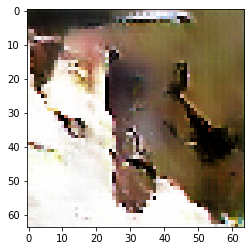

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 29

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.646286249160767 sec
Gen loss: 0.6937762174179883, Disc loss: 1.4439355500022246, Disc valid real loss: 0.6926513769762302, Disc valid fake loss: 0.6918142300634204, Disc class real loss: 0.05946994414108207
Time for epoch 2 is 13.610707521438599 sec
Gen loss: 0.6974799909242769, Disc loss: 1.4504116150098765, Disc valid real loss: 0.6950794632841901, Disc valid fake loss: 0.6899262896075158, Disc class real loss: 0.06540585938832587
Time for epoch 3 is 13.623966217041016 sec
Gen loss: 0.6922918370745692, Disc loss: 1.441675693362063, Disc valid real loss: 0.6910145311820798, Disc valid fake loss: 0.6932851349112141, Disc class real loss: 0.05737602816600891
Time for epoch 4 is 13.564162492752075 sec
Gen loss: 0.6968075309988606, Disc loss: 1.444338195692233, Disc valid real loss: 0.692539136422682, Disc valid fake loss: 0.6914382150502709, Disc cla

Time for epoch 37 is 13.654717206954956 sec
Gen loss: 0.6921220546169333, Disc loss: 1.4460041933266452, Disc valid real loss: 0.6917241609839566, Disc valid fake loss: 0.6935133253978844, Disc class real loss: 0.060766708046421654
Time for epoch 38 is 13.625145435333252 sec
Gen loss: 0.6915706740162237, Disc loss: 1.4452964135301791, Disc valid real loss: 0.6906707443519013, Disc valid fake loss: 0.6941850726520465, Disc class real loss: 0.06044059306926405
Time for epoch 39 is 13.652089834213257 sec
Gen loss: 0.6955422077398636, Disc loss: 1.4586950433932668, Disc valid real loss: 0.6927872526290294, Disc valid fake loss: 0.6919686211156975, Disc class real loss: 0.07393916813490425
Time for epoch 40 is 13.614370584487915 sec
Gen loss: 0.6986044238253337, Disc loss: 1.4488699077590694, Disc valid real loss: 0.6951830542184473, Disc valid fake loss: 0.6895570341487564, Disc class real loss: 0.06412981594887864
Time for epoch 41 is 13.60922646522522 sec
Gen loss: 0.6959008828088197, Di

Time for epoch 73 is 13.618603944778442 sec
Gen loss: 0.6922489866654724, Disc loss: 1.455410562879671, Disc valid real loss: 0.6903705593693225, Disc valid fake loss: 0.6943661060113571, Disc class real loss: 0.07067389837641351
Time for epoch 74 is 13.603246450424194 sec
Gen loss: 0.6966855033303341, Disc loss: 1.4377091131236173, Disc valid real loss: 0.6944066552611871, Disc valid fake loss: 0.6902975572480096, Disc class real loss: 0.053004905000822326
Time for epoch 75 is 13.63386082649231 sec
Gen loss: 0.6950662434908755, Disc loss: 1.4573148185321632, Disc valid real loss: 0.6931498788882723, Disc valid fake loss: 0.6911388110662218, Disc class real loss: 0.07302612631636461
Time for epoch 76 is 13.60542368888855 sec
Gen loss: 0.6933262950682705, Disc loss: 1.4431054559826528, Disc valid real loss: 0.6930992015332065, Disc valid fake loss: 0.6917529842717861, Disc class real loss: 0.05825327106358205
Time for epoch 77 is 13.609289169311523 sec
Gen loss: 0.6942085166610676, Disc

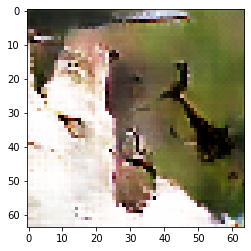

In [69]:
next_starting_checkpoint = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=30, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_class_real_hist=disc_class_loss_real_hist,
                                      d_class_fake_hist=disc_class_loss_fake_hist,
                                      noise=noise100,
                                      label=label,
                                      save_files=True)

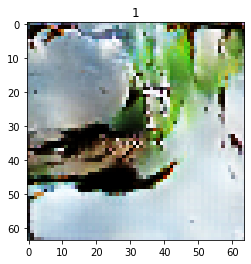

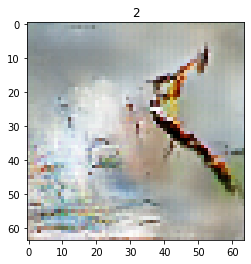

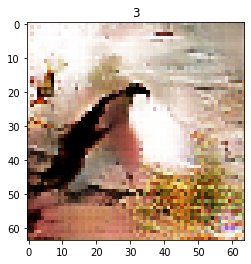

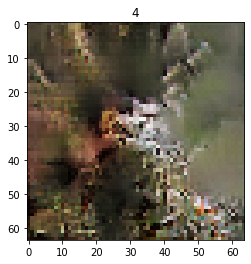

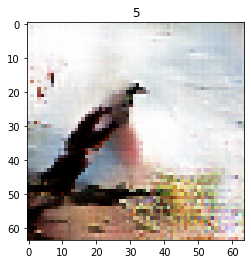

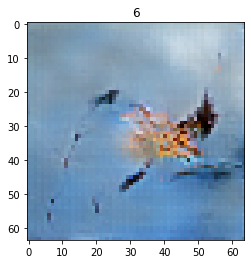

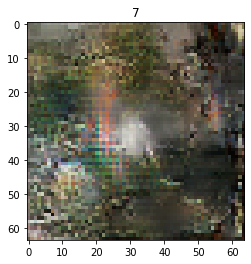

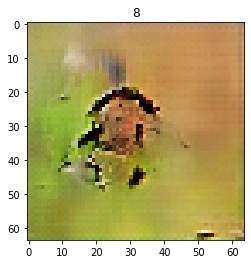

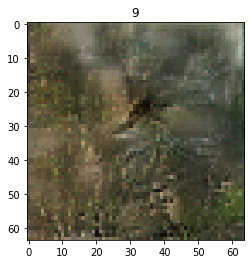

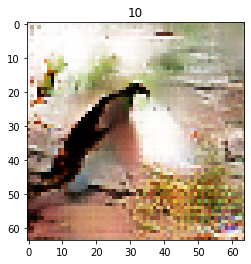

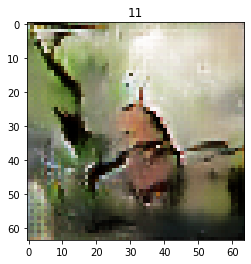

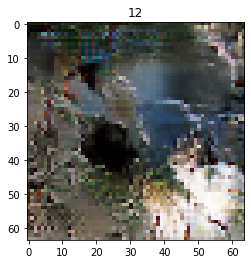

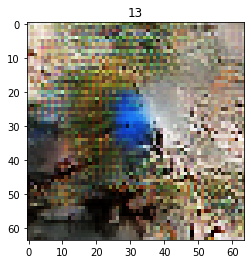

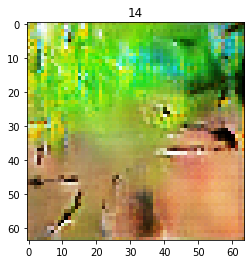

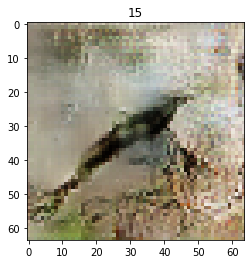

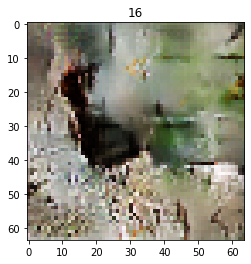

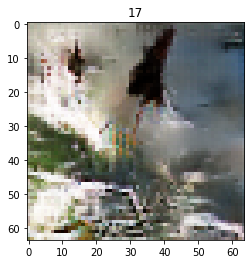

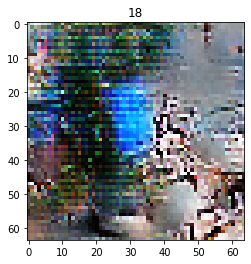

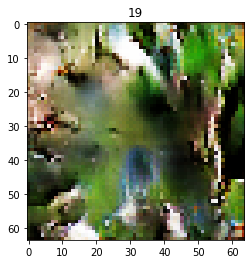

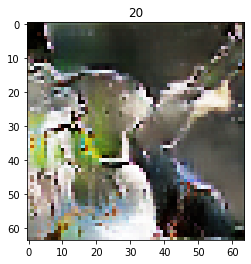

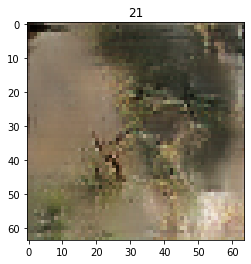

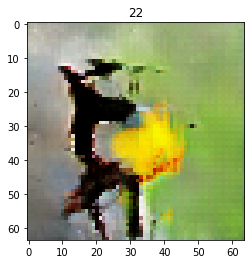

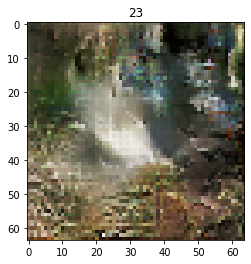

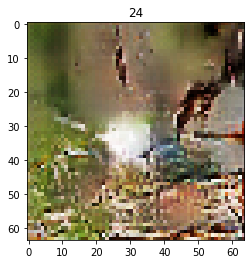

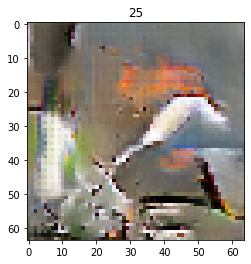

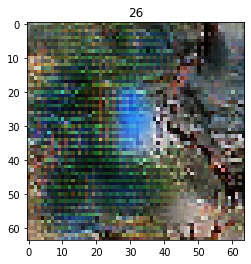

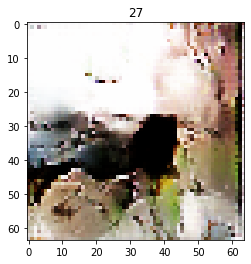

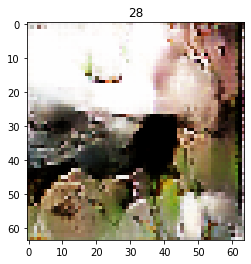

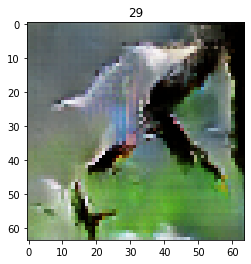

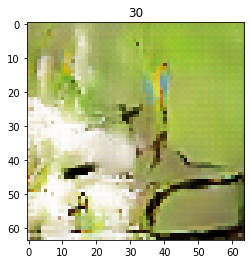

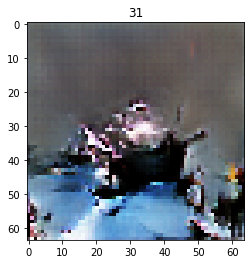

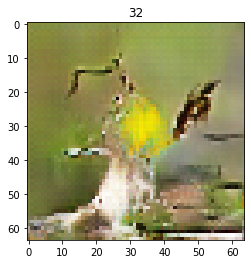

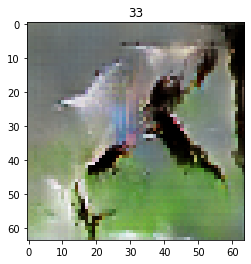

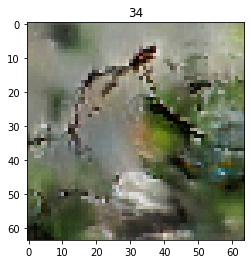

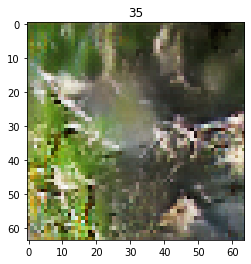

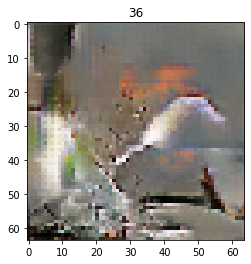

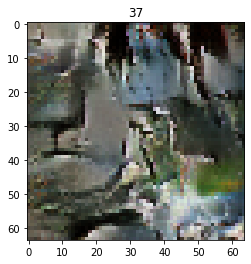

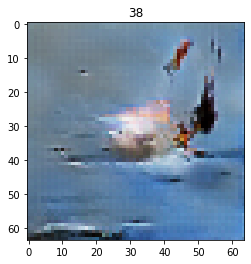

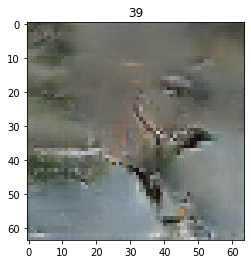

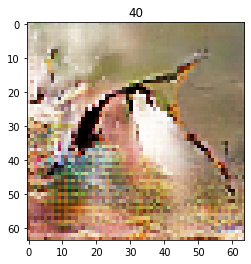

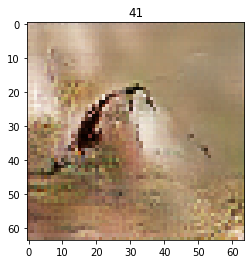

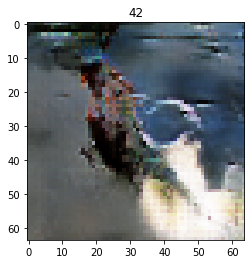

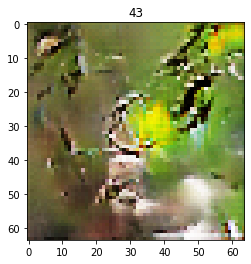

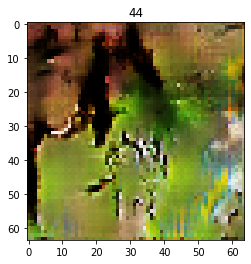

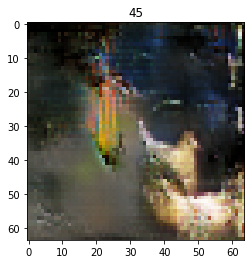

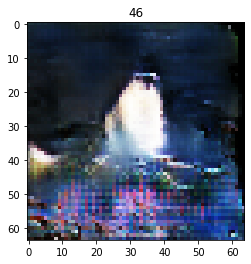

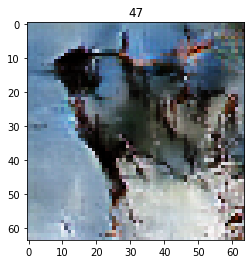

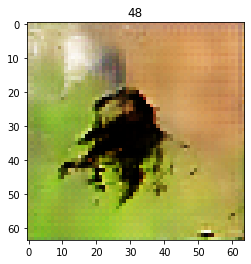

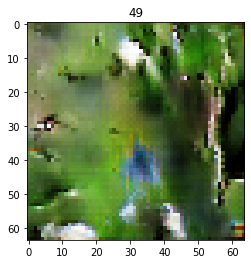

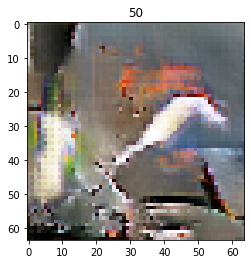

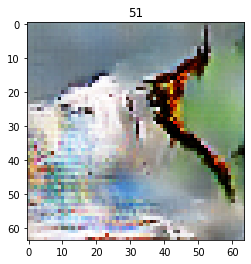

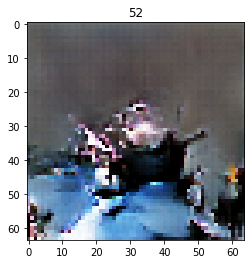

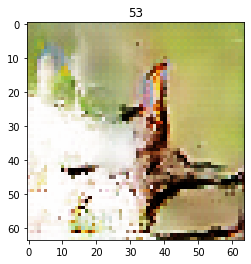

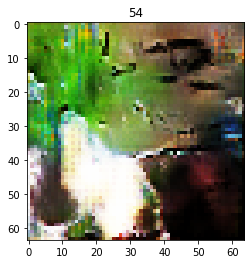

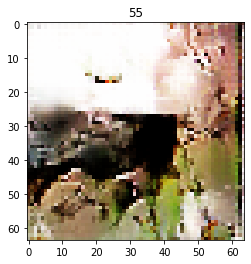

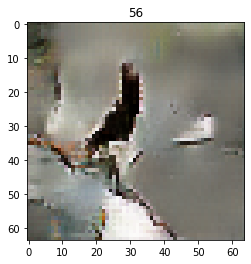

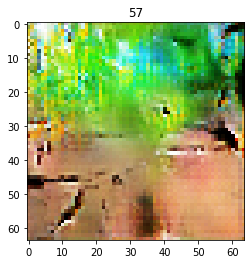

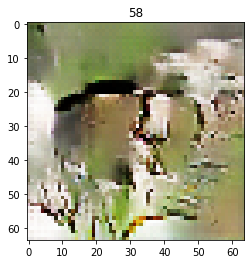

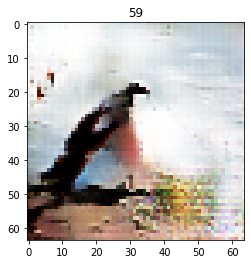

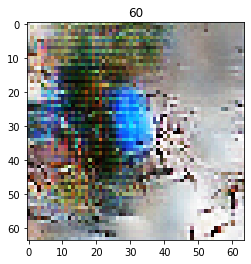

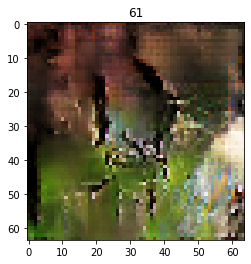

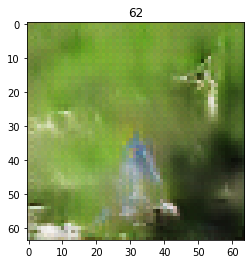

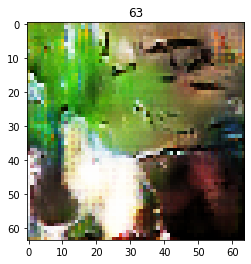

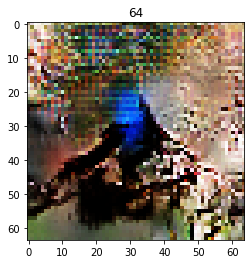

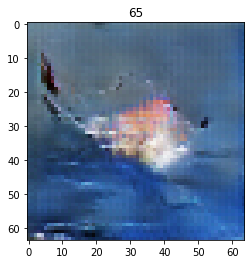

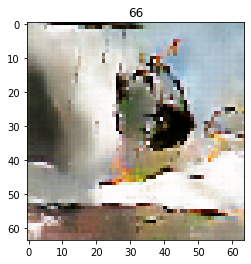

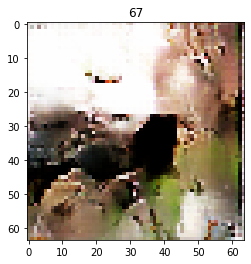

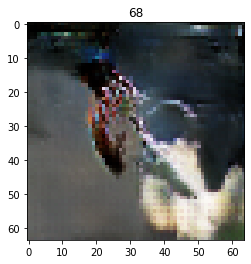

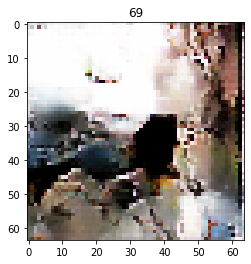

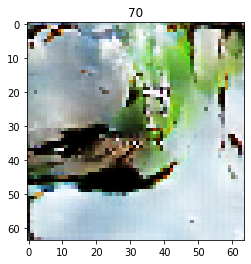

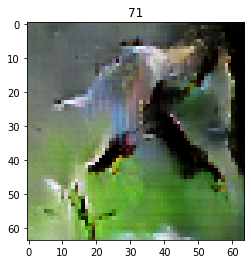

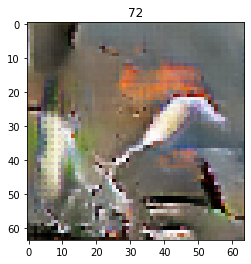

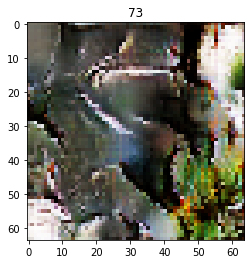

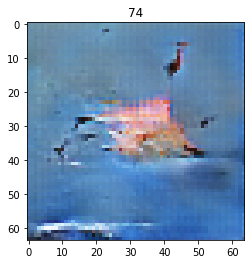

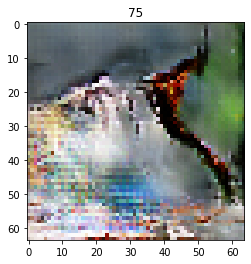

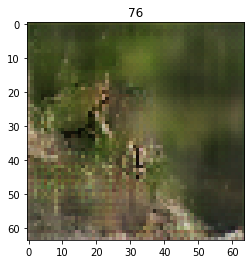

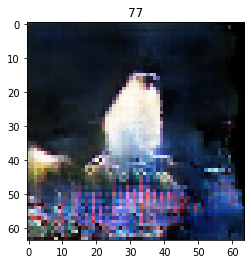

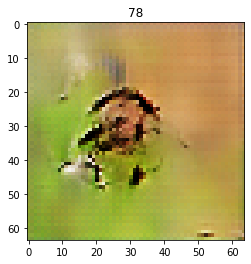

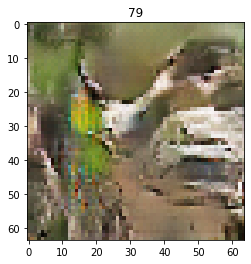

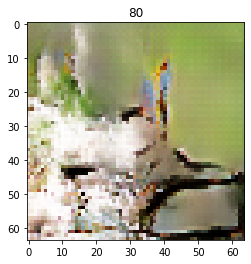

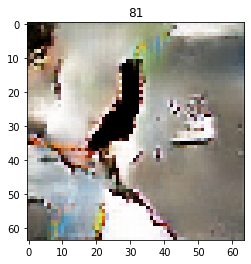

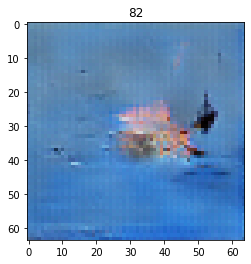

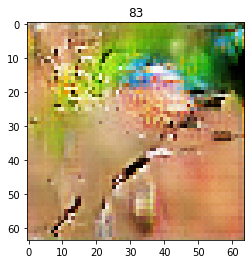

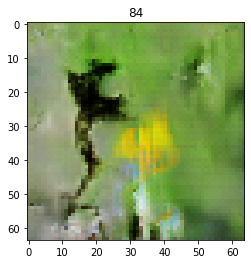

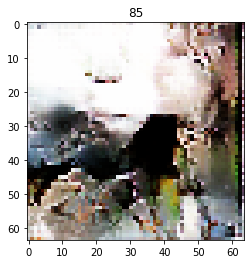

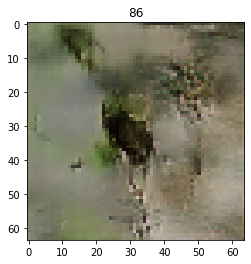

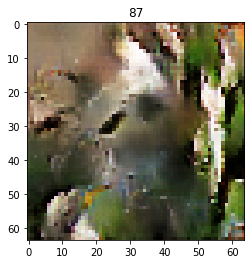

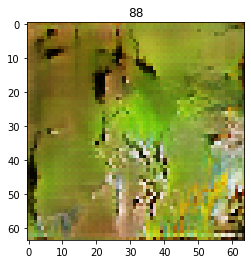

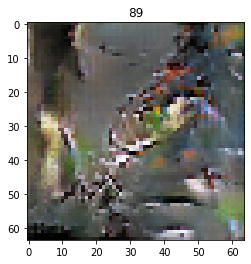

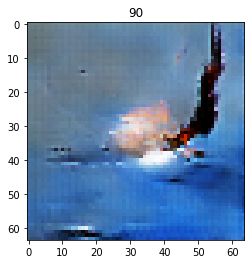

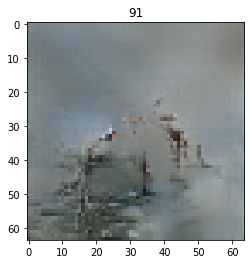

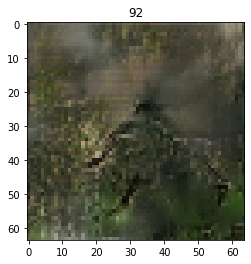

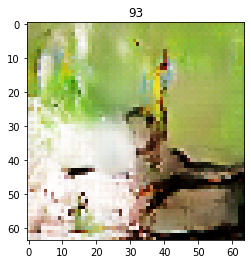

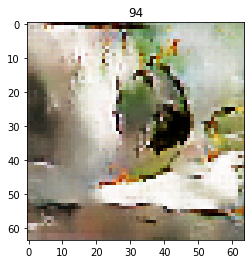

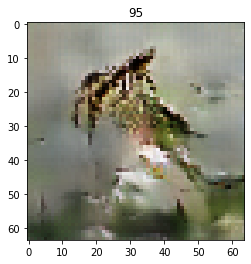

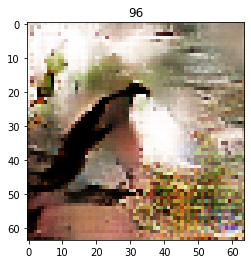

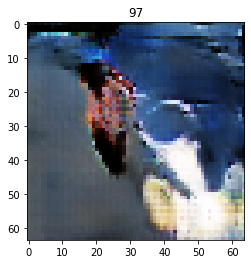

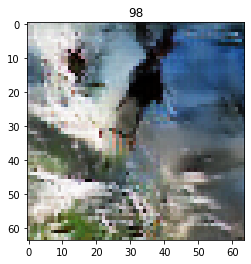

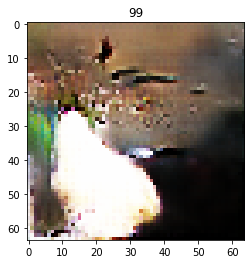

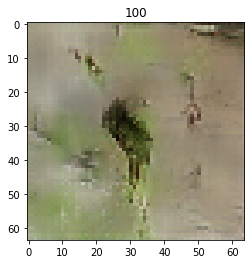

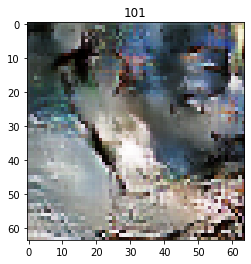

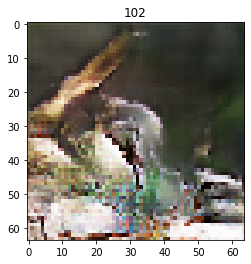

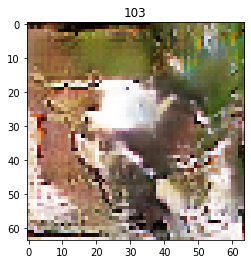

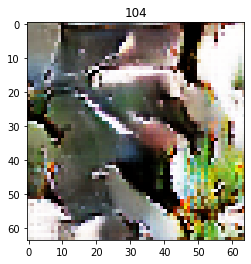

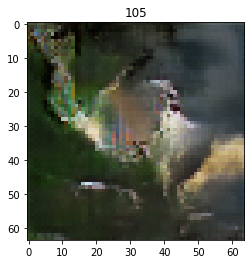

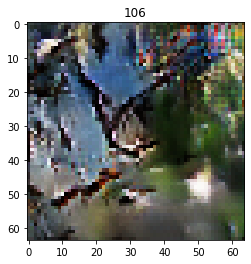

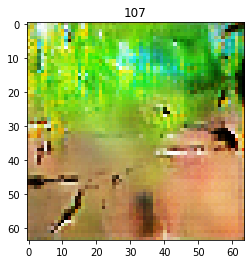

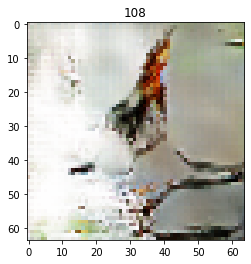

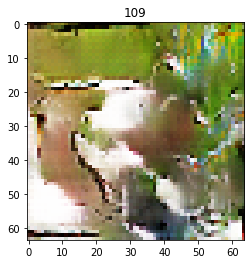

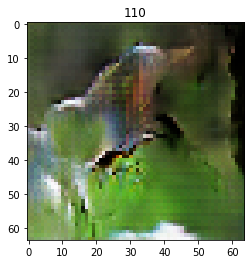

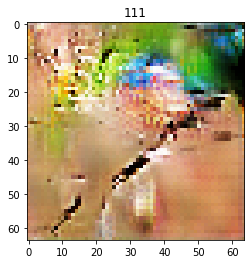

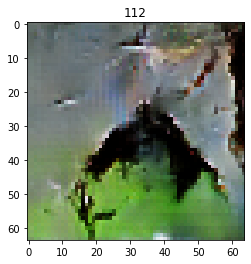

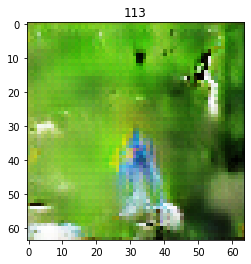

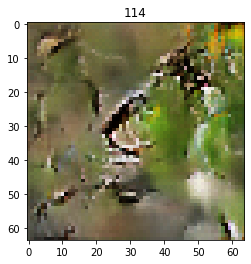

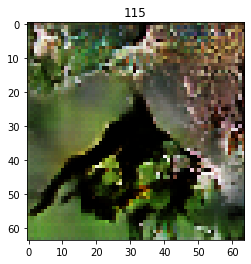

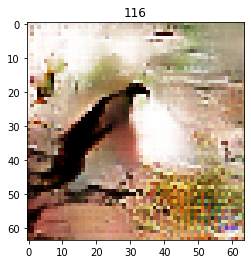

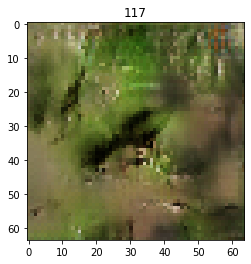

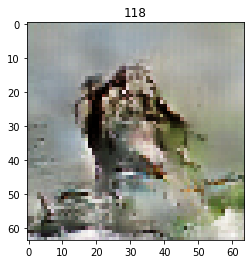

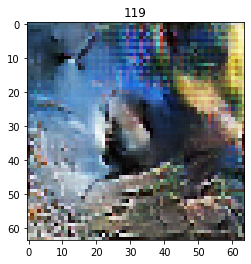

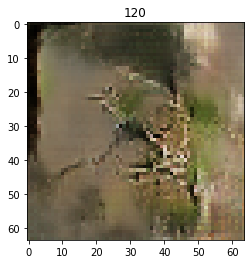

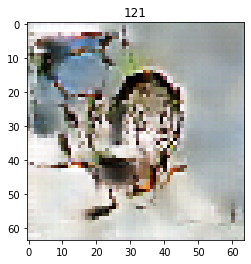

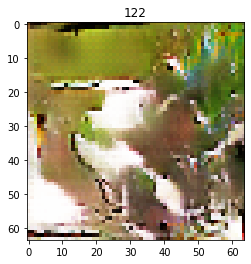

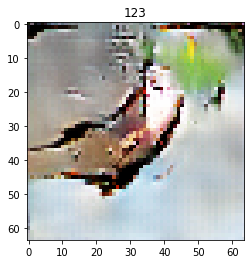

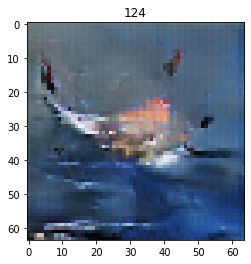

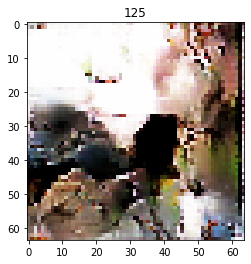

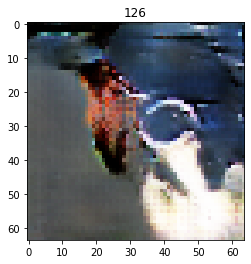

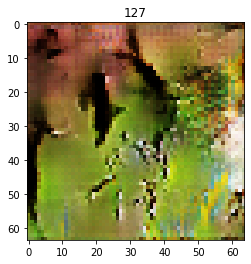

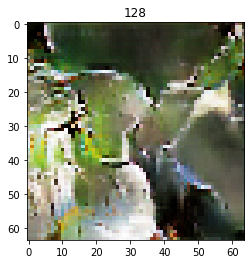

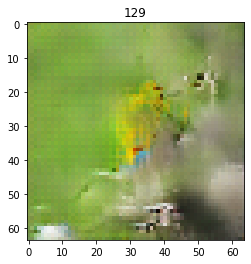

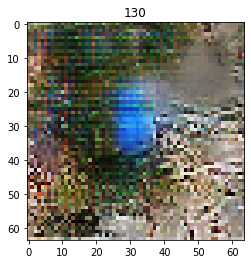

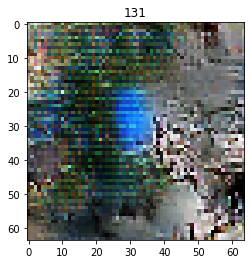

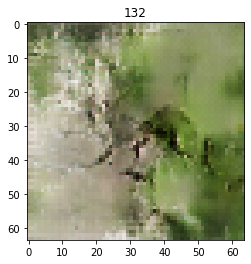

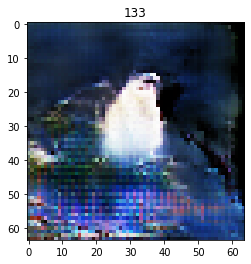

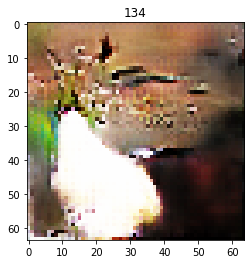

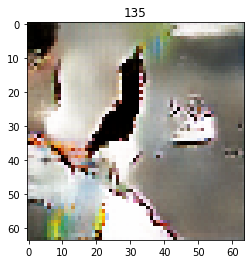

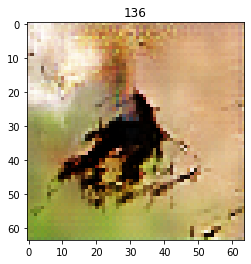

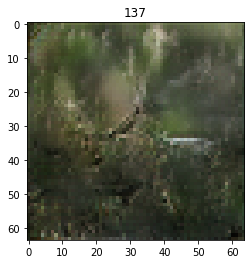

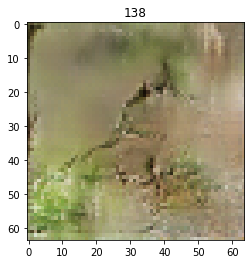

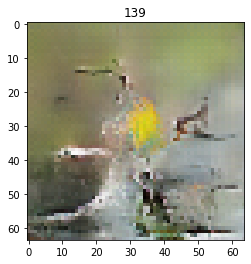

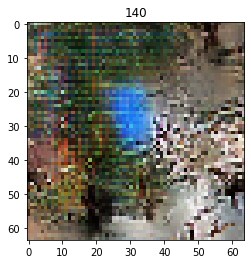

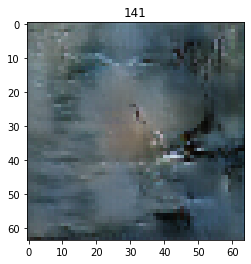

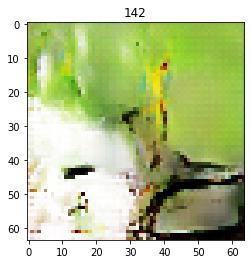

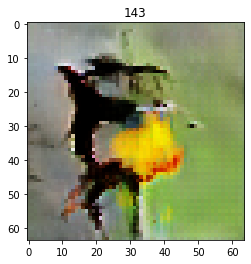

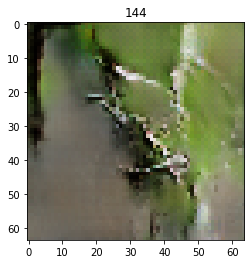

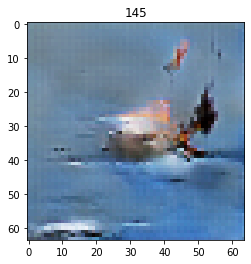

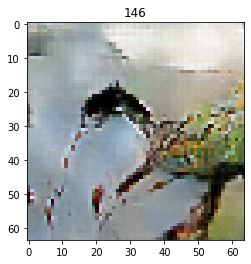

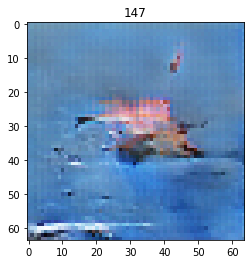

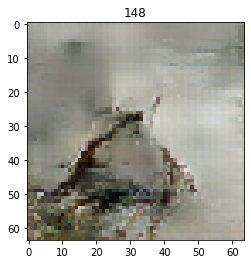

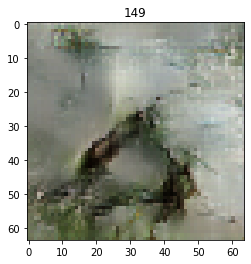

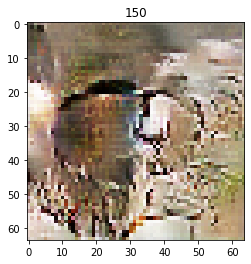

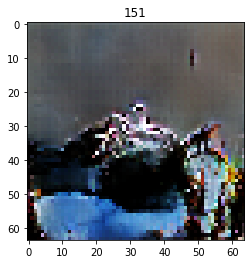

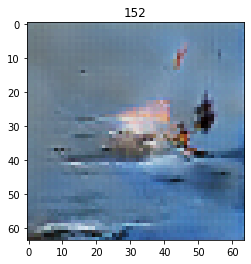

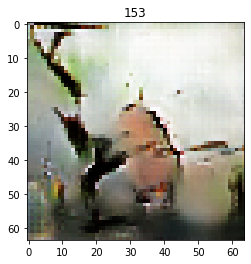

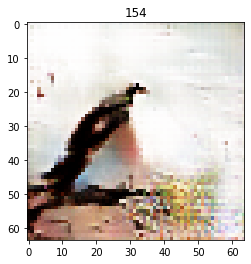

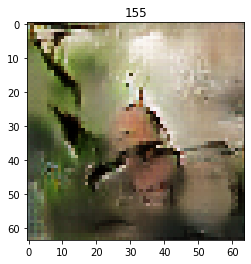

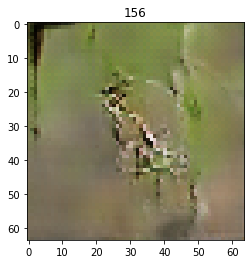

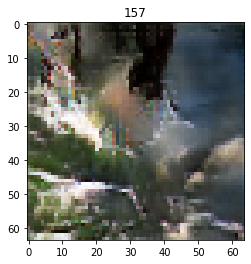

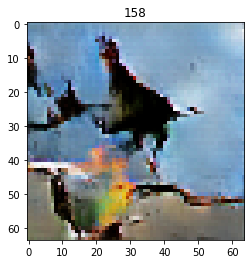

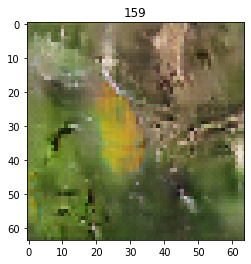

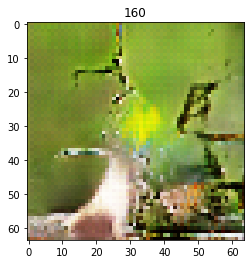

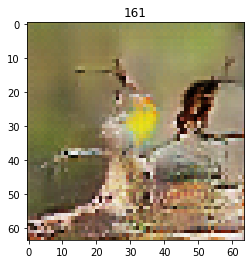

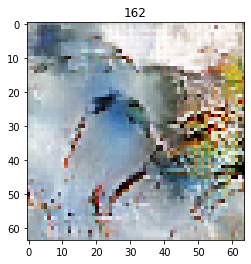

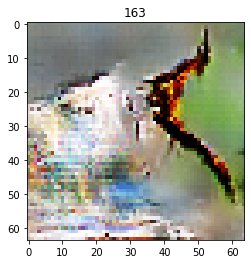

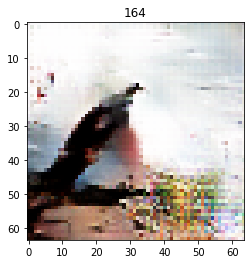

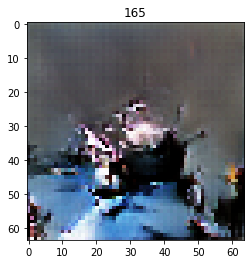

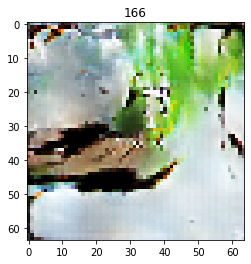

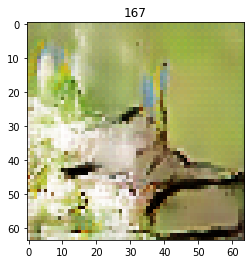

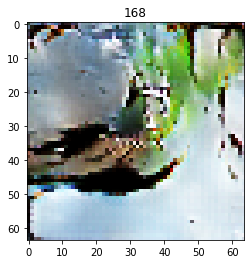

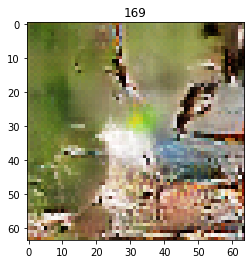

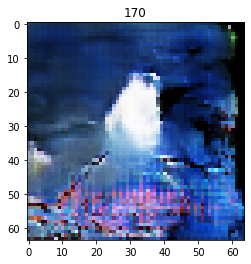

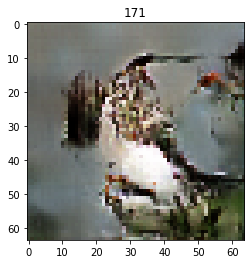

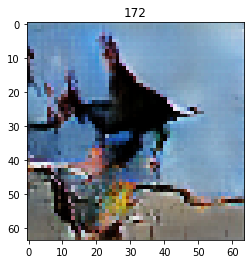

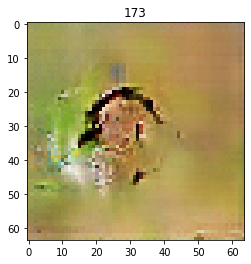

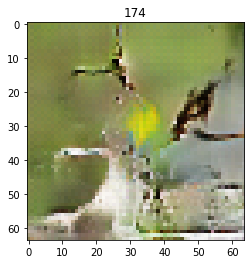

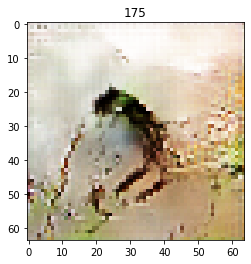

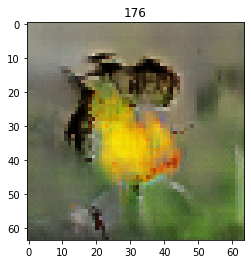

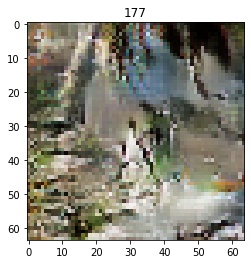

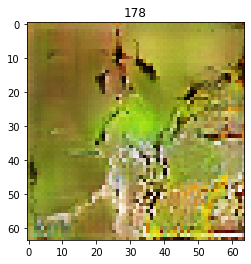

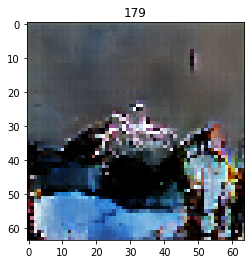

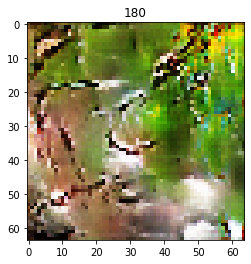

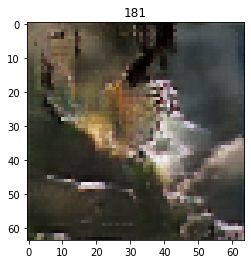

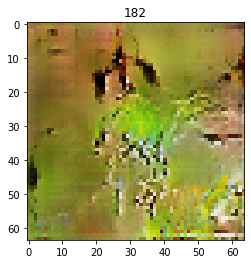

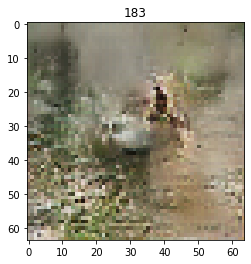

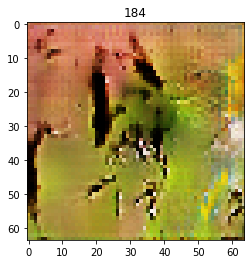

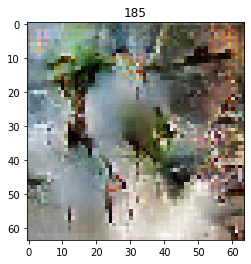

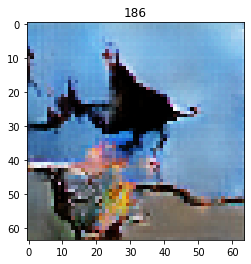

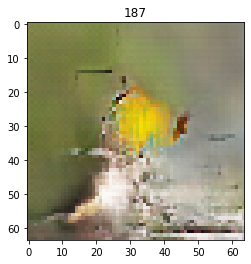

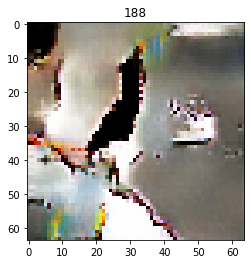

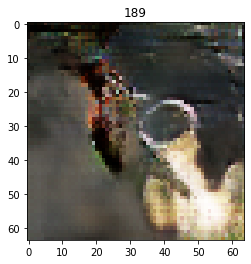

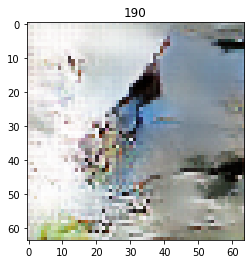

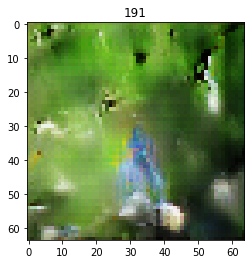

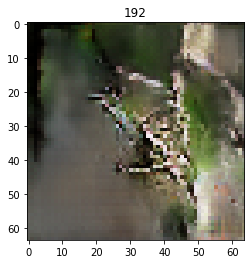

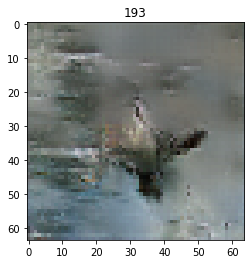

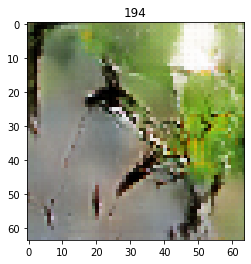

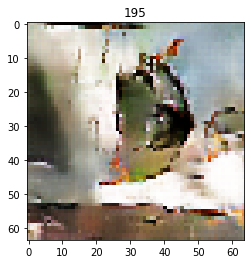

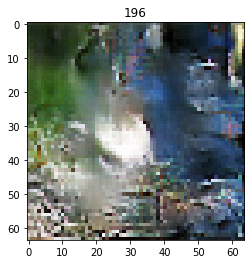

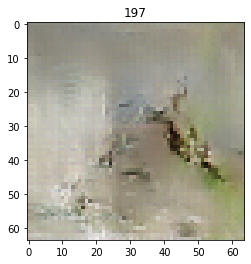

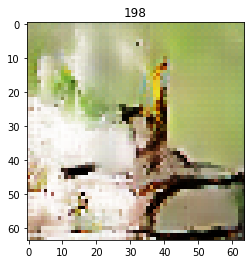

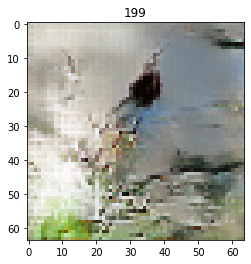

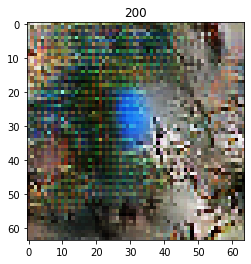

In [82]:
noise = np.random.normal(0, 1, 100)
for label in range(200):

    generated_image = generator.predict([np.array([noise]), np.array([label])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.title(label+1)
    plt.show()

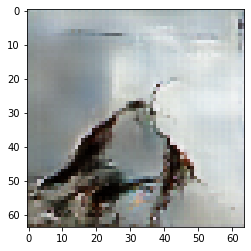

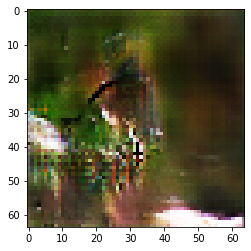

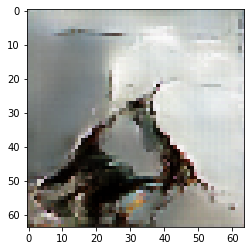

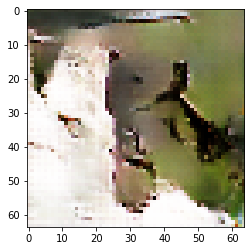

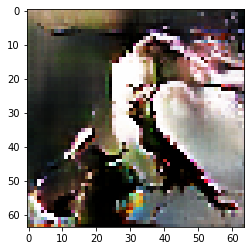

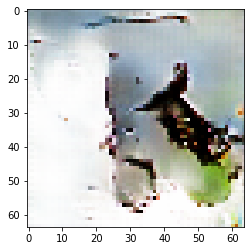

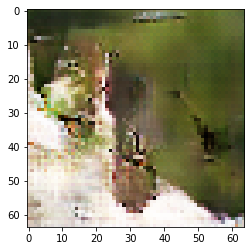

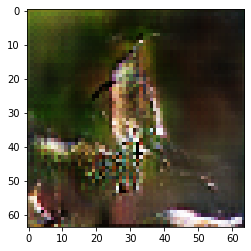

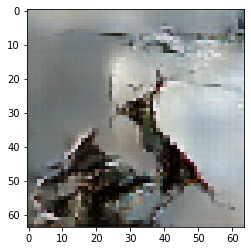

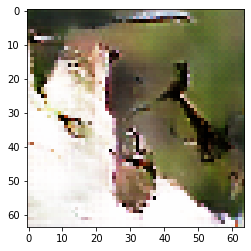

In [78]:

for label in range(10):
    noise = np.random.normal(0, 1, 100)
    generated_image = generator.predict([np.array([noise]), np.array([75])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()

In [ ]:
# noise = np.random.normal(0, 1, 100)
for label in range(10):

    generated_image = generator.predict([np.array([noise]), np.array([label])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()

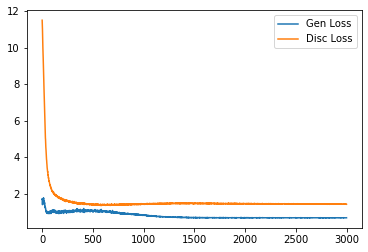

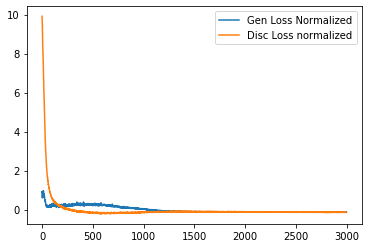

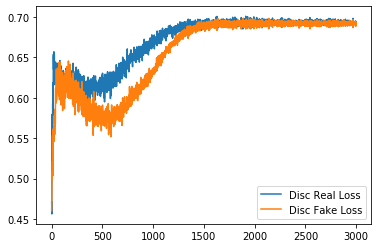

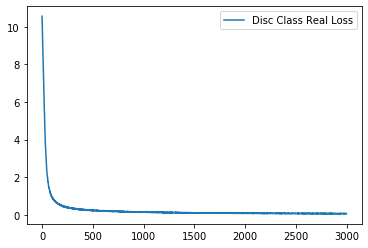

In [72]:
plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)

plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()

plt.plot(disc_class_loss_real_hist)
# plt.plot(disc_class_loss_fake_hist)
plt.legend(['Disc Class Real Loss', 'Disc Class Fake Loss'])
plt.show()
